# DeckDetect

Este proyecto tiene como objetivo detectar y reconocer automáticamente cartas de la baraja de póker a partir de una imagen tomada con una cámara o cargada desde un archivo. El sistema identifica cada carta visible en la imagen, extrae su contenido y determina su número (valor) y su palo.

## Objetivos principales:
- Detectar todas las cartas visibles en una imagen.
- Corregir la perspectiva para obtener una vista frontal de cada carta.
- Ajustar la orientación para que el número y el palo estén correctamente posicionados.
- Extraer las regiones correspondientes al número y al palo.
- Comparar dichas regiones con plantillas de referencia.
- Identificar y clasificar cada carta según su valor y su palo.

## Baraja utilizada:
Se utiliza la baraja estándar de póker:

- 13 valores (ranks): Ace, Two, Three, ..., Ten, Jack, Queen, King.
- 4 palos (suits): Clubs, Diamonds, Hearts, Spades.

## Flujo de procesamiento:
1. Preprocesamiento de imagen: conversión a escala de grises, detección de bordes y dilatación.
1. Detección de cartas: identificación de contornos con forma cuadrilátera.
1. Transformación de perspectiva: recorte alineado de cada carta.
1. Corrección de orientación: rotación para asegurar que el número esté arriba a la izquierda.
1. Extracción de número y palo: recorte de la esquina superior izquierda.
1. Comparación con plantillas: búsqueda del número y palo más parecidos.
1. Resultado final: identificación completa de la carta (por ejemplo, "King of Hearts").

## 1. Preparación del entorno
Importamos las librerías necesarias: OpenCV para procesamiento de imágenes, NumPy para operaciones matemáticas, Matplotlib para visualizar, y glob/os para gestionar archivos.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

## 2. Preprocesamiento de las cartas
Esta función convierte una imagen a escala de grises, le aplica un filtro de desenfoque para reducir el ruido, detecta bordes con Canny, y luego los refuerza con dilatación.

In [2]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 42, 89)
    kernel = np.ones((2, 2))
    dilated = cv2.dilate(canny, kernel=kernel, iterations=2)
    return dilated

Aqui tenemos un pequeño ejemplo para ver su funcionamiento:

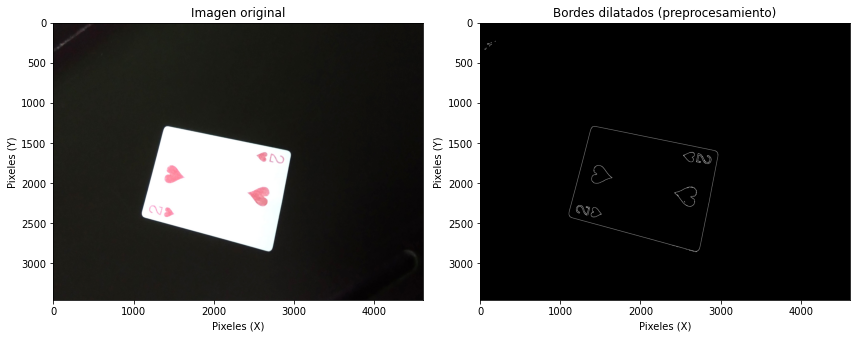

In [3]:
img = cv2.imread("Fotos/fotos_complejas/2H27.jpg")
edges = preprocess_image(img)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Imagen original")
axs[0].set_xlabel("Pixeles (X)")
axs[0].set_ylabel("Pixeles (Y)")

axs[1].imshow(edges, cmap='gray')
axs[1].set_title("Bordes dilatados (preprocesamiento)")
axs[1].set_xlabel("Pixeles (X)")
axs[1].set_ylabel("Pixeles (Y)")

plt.tight_layout()
plt.show()

## 3. Detección de contornos de cartas

Una vez tenemos la imagen procesada, buscamos contornos que representen cartas.

- Usamos cv2.findContours con RETR_TREE para obtener la jerarquía de contornos (útil para descartar los internos).
- Filtramos contornos externos y con un área mínima para evitar falsos positivos.
- Aplicamos approxPolyDP sobre el convex hull del contorno para obtener una forma más regular.
- Si el contorno tiene 4 lados, lo consideramos una carta. Si no, usamos un método alternativo (minAreaRect) para obtener una caja rectangular aproximada.

Resultado: una lista de contornos que representan cartas detectadas.

In [4]:
def find_card_contours(edges):
    # Usamos RETR_TREE para tener jerarquía y descartar contornos internos
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    card_contours = []

    if hierarchy is None:
        return card_contours

    hierarchy = hierarchy[0]
    
    for i, cnt in enumerate(contours):
        # Solo consideramos contornos sin padre (externos)
        if hierarchy[i][3] != -1:
            continue

        area = cv2.contourArea(cnt)
        if area < 3000:
            continue

        # Suavizamos la forma con convex hull
        hull = cv2.convexHull(cnt)
        perimeter = cv2.arcLength(hull, closed=True)
        approx = cv2.approxPolyDP(hull, 0.015 * perimeter, closed=True)

        if len(approx) == 4:
            card_contours.append(approx)
        else:
            # Si el hull+approx aún falla, usar minAreaRect como fallback
            rect = cv2.minAreaRect(cnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            card_contours.append(box.reshape(-1, 1, 2))

    return card_contours

Aqui tenemos un ejemplo de la función para encontrar los contornos de una carta:

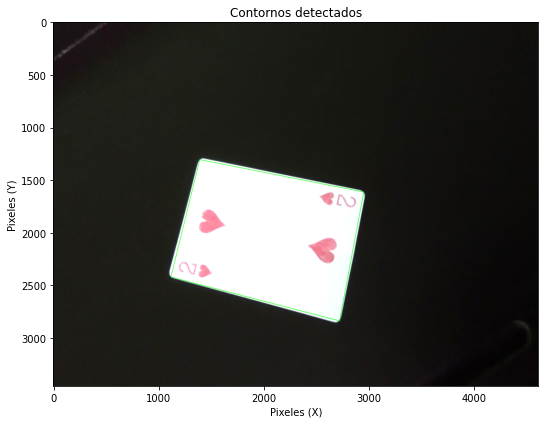

In [5]:
edges = preprocess_image(img)
contornos = find_card_contours(edges)

# Dibujar los contornos detectados sobre una copia de la imagen original
img_contornos = img.copy()
cv2.drawContours(img_contornos, contornos, -1, (0, 255, 0), 3)

# Mostrar resultado
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB))
plt.title("Contornos detectados")
plt.xlabel("Pixeles (X)")
plt.ylabel("Pixeles (Y)")
plt.tight_layout()
plt.show()

## 4. Ordenar esquinas del contorno

Cuando detectamos una carta, sus 4 esquinas pueden estar en cualquier orden. Esta función reorganiza esos puntos para que siempre estén en el orden correcto:

1. Top-left
1. Top-right
1. Bottom-right
1. Bottom-left

Esto es esencial para poder aplicar correctamente una transformación de perspectiva más adelante. También incluye una verificación extra por si se detectan coordenadas duplicadas (poco común, pero posible).

In [7]:
def sort_corners(pts):
    pts = np.array(pts, dtype="float32")
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    tl_index = np.argmin(s)
    br_index = np.argmax(s)
    tr_index = np.argmin(diff)
    bl_index = np.argmax(diff)

    # Asegurar que todos los índices sean distintos
    used = {tl_index, br_index, tr_index, bl_index}
    if len(used) < 4:
        # Si hay repetidos, hacer una asignación más segura
        # Ordenar por Y (de arriba a abajo), luego X
        sorted_pts = sorted(pts, key=lambda p: (p[1], p[0]))
        top_two = sorted(sorted_pts[:2], key=lambda p: p[0])  # izq, der
        bottom_two = sorted(sorted_pts[2:], key=lambda p: p[0])  # izq, der
        rect[0], rect[1] = top_two
        rect[3], rect[2] = bottom_two
    else:
        rect[0] = pts[tl_index]
        rect[2] = pts[br_index]
        rect[1] = pts[tr_index]
        rect[3] = pts[bl_index]

    return rect

A continuación mostramos cómo se aplica la función sort_corners sobre una carta detectada. Dibujamos los cuatro vértices sobre la imagen original, marcando cada uno con un número grande para representar su posición ordenada (0: Top-Left, 1: Top-Right, 2: Bottom-Right, 3: Bottom-Left).

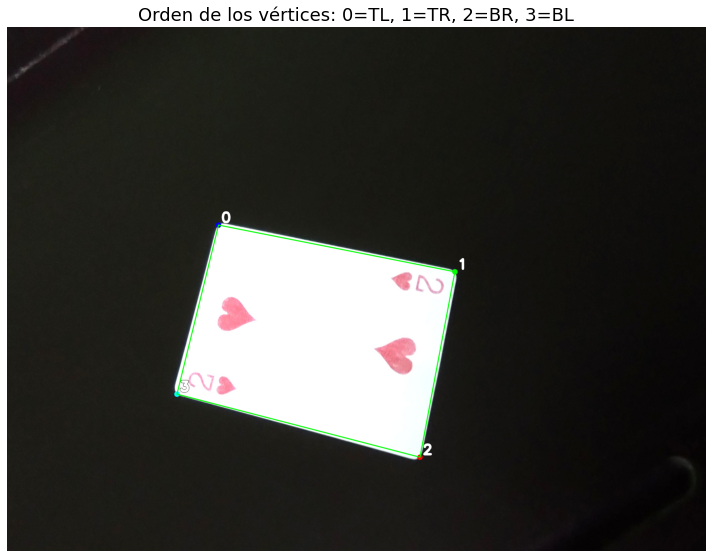

In [8]:
img = cv2.imread("Fotos/fotos_complejas/2H27.jpg")
edges = preprocess_image(img)
contours = find_card_contours(edges)

if contours:
    first_card = contours[0].reshape(4, 2)
    sorted_pts = sort_corners(first_card)

    img_corners = img.copy()

    # Colores distintos para cada vértice (BGR)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    labels = ["0", "1", "2", "3"]

    # Dibujar círculos y etiquetas grandes
    for i, point in enumerate(sorted_pts):
        x, y = int(point[0]), int(point[1])
        cv2.circle(img_corners, (x, y), 18, colors[i], -1)

        # Texto grande con borde negro y relleno blanco
        cv2.putText(img_corners, labels[i], (x + 20, y - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 3.0, (0, 0, 0), 20)  # sombra negra
        cv2.putText(img_corners, labels[i], (x + 20, y - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 3.0, (255, 255, 255), 15)  # texto blanco

    # Dibujar líneas conectando los puntos
    for i in range(4):
        pt1 = tuple(sorted_pts[i].astype(int))
        pt2 = tuple(sorted_pts[(i + 1) % 4].astype(int))
        cv2.line(img_corners, pt1, pt2, (0, 255, 0), 5)

    # Mostrar imagen resultante
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
    plt.title("Orden de los vértices: 0=TL, 1=TR, 2=BR, 3=BL", fontsize=18)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No se detectaron cartas.")


## 5. Transformación de perspectiva (warp)
Una vez tenemos los 4 puntos de una carta en el orden correcto, esta función aplica una transformación de perspectiva para obtener una vista frontal, como si estuviéramos mirando la carta directamente desde arriba.

Pasos que realiza:

1. Calcula las dimensiones reales de la carta usando distancias entre esquinas.
1. Define una nueva cuadrícula rectangular para la carta ya rectificada.
1. Aplica una transformación de perspectiva para que la carta aparezca vertical y recortada.

Resultado: una imagen limpia, alineada y lista para analizar su contenido (número y palo).

In [9]:
def warp_card(image, contour):
    contour = contour.reshape(4, 2)
    ordered = sort_corners(contour)
    (tl, tr, br, bl) = ordered
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxWidth = int(max(widthA, widthB))
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(ordered, dst)
    warp = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warp

En este ejemplo aplicamos la función warp_card sobre la primera carta detectada en la imagen. A la izquierda mostramos la imagen original con el contorno de la carta marcado en verde, y a la derecha el resultado de la transformación: la carta recortada y corregida en perspectiva, como si la viéramos desde una vista frontal

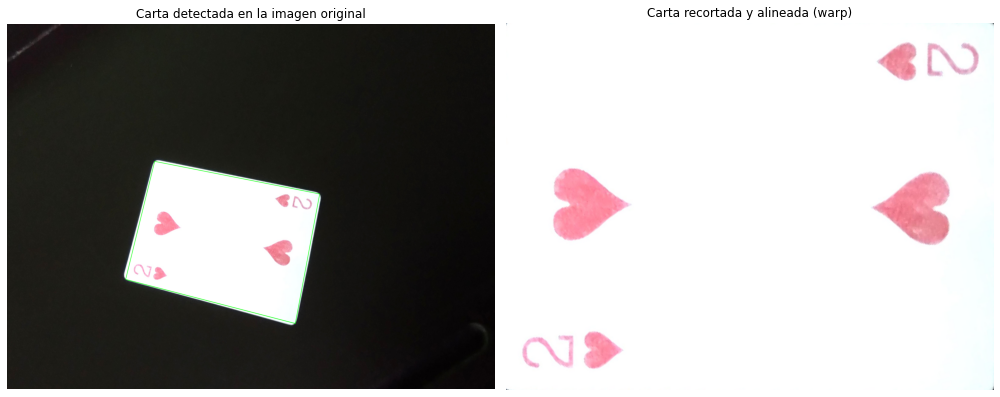

In [10]:
# Cargar imagen y detectar contornos
img = cv2.imread("Fotos/fotos_complejas/2H27.jpg")
edges = preprocess_image(img)
contours = find_card_contours(edges)

if contours:
    # Tomar el primer contorno detectado
    first_card = contours[0]
    
    # Aplicar transformación en perspectiva
    carta_recortada = warp_card(img, first_card)
    
    # Mostrar imagen original con contorno y resultado recortado
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Imagen original con contorno
    img_con_contorno = img.copy()
    cv2.drawContours(img_con_contorno, [first_card], -1, (0, 255, 0), 3)
    axs[0].imshow(cv2.cvtColor(img_con_contorno, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Carta detectada en la imagen original")
    axs[0].axis("off")
    
    # Imagen recortada (alineada)
    axs[1].imshow(cv2.cvtColor(carta_recortada, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Carta recortada y alineada (warp)")
    axs[1].axis("off")
    
    plt.tight_layout()
    plt.show()
else:
    print("No se detectaron cartas en la imagen.")


## 6. Corrección de orientación de la carta
Esta función verifica si la carta se encuentra en la orientación vertical adecuada, es decir, que su alto sea mayor que su ancho. Esto es útil como una primera etapa de corrección, especialmente después de recortar la carta desde la imagen original.

Para ello, se evalúan las dimensiones de la imagen y, si es necesario, se rota 90° en sentido horario para que la carta quede en posición vertical.


¿Cómo lo hace?

- Se obtienen las dimensiones de la imagen (`alto` y `ancho`).
- Si el **ancho** es mayor que el **alto**, se asume que la carta está girada.
- Se realiza una rotación de **90° en sentido horario** (`cv2.ROTATE_90_CLOCKWISE`).
- Si el parámetro `debug=True`, se muestran mensajes informativos del proceso.


In [11]:
def correct_card_orientation(card_img, debug=False):
    h, w = card_img.shape[:2]

    if debug:
        print(f"Dimensiones - Alto: {h}, Ancho: {w}")

    # Si la imagen es más ancha que alta, rotamos 90°
    if w > h:
        if debug:
            print("Rotando la carta 90° en sentido horario")
        card_img = cv2.rotate(card_img, cv2.ROTATE_90_CLOCKWISE)

    return card_img

Ahora aqui veremos un ejemplo de la función correct_card_orientation, donde primero se buscan los contornos de la carta y luego se orienta la carta:

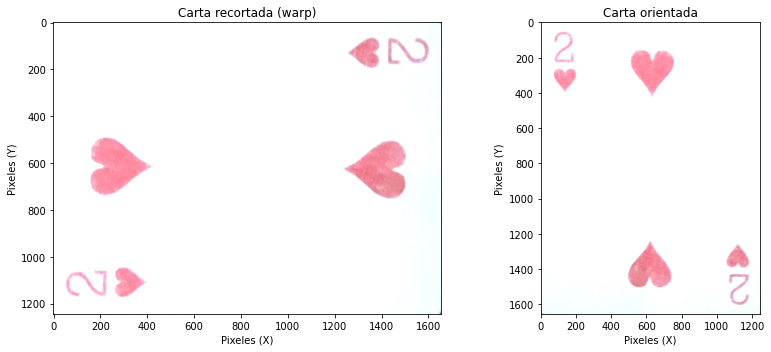

In [12]:
contornos = find_card_contours(preprocess_image(img))

if contornos:
    warped = warp_card(img, contornos[0])
    oriented = correct_card_orientation(warped)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Carta recortada (warp)")
    axs[0].set_xlabel("Pixeles (X)")
    axs[0].set_ylabel("Pixeles (Y)")

    axs[1].imshow(cv2.cvtColor(oriented, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Carta orientada")
    axs[1].set_xlabel("Pixeles (X)")
    axs[1].set_ylabel("Pixeles (Y)")

    plt.tight_layout()
    plt.show()

## 7. Validación de proporción de la carta

La función `is_valid_card_proportion` verifica si la carta rectificada tiene una proporción (alto/ancho) razonable.

Esto sirve para descartar deformaciones por errores en el proceso de recorte o warping.

La proporción esperada es aproximadamente 1:1. Se permite un margen (`jump_ratio`) para evitar rechazar cartas ligeramente distorsionadas.

Devuelve `True` si la proporción está dentro del rango aceptable.

In [13]:
def is_valid_card_proportion(warped_img, jump_ratio=0.8, debug=False):
    h, w = warped_img.shape[:2]
    ratio = h / w if w != 0 else 0

    res = (1 - jump_ratio <= ratio) and (ratio <= 1 + jump_ratio)
    
    if debug:
        print(f"[DEBUG] Dimensiones carta: {w}x{h} | Ratio: {ratio:.2f} | {1-jump_ratio } <= {ratio:.2f} <= {1 + jump_ratio}\n\tResultado:{res}")

    return res

[DEBUG] Dimensiones carta: 1244x1655 | Ratio: 1.33 | 0.19999999999999996 <= 1.33 <= 1.8
	Resultado:True


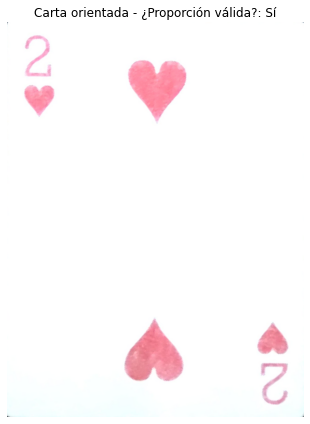

In [14]:
contornos = find_card_contours(preprocess_image(img))

if contornos:
    warped = warp_card(img, contornos[0])
    oriented = correct_card_orientation(warped)

    # Validar proporción de la carta orientada
    es_valida = is_valid_card_proportion(oriented, debug=True)

    # Visualizar resultado
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(oriented, cv2.COLOR_BGR2RGB))
    plt.title(f"Carta orientada - ¿Proporción válida?: {'Sí' if es_valida else 'No'}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No se detectaron cartas.")


## 8. Binarización de una región
Esta función convierte una región (en escala de grises o en color) en una imagen binaria, donde los elementos relevantes (como números o palos) quedan en blanco sobre fondo negro.

Pasos que realiza:

1. Asegura que los parámetros `block_size` y blur_ksize sean impares, ya que así lo requiere OpenCV.
1. Convierte la región a escala de grises si aún no lo está.
1. Aplica CLAHE (opcional, pero activado por defecto) para mejorar el contraste local, útil cuando la imagen tiene iluminación desigual.
1. Suaviza la imagen con un desenfoque gaussiano para reducir el ruido.
1. Aplica un umbral adaptativo con inversión (`THRESH_BINARY_INV`), lo que resalta las zonas oscuras sobre fondo claro.

Este proceso mejora la segmentación de caracteres y palos para su posterior análisis.

In [16]:
def binarize_region(region, block_size=15, C=2, blur_ksize=5, use_clahe=True):
    # Asegura que el block_size y blur_ksize sean impares
    block_size = block_size if block_size % 2 == 1 else block_size + 1
    blur_ksize = blur_ksize if blur_ksize % 2 == 1 else blur_ksize + 1
    
    # Conversión a escala de grises si es necesario
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY) if len(region.shape) == 3 else region

    # Mejora de contraste local con CLAHE (opcional pero muy efectivo)
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

    # Suavizado con Gaussian Blur (reduce ruido antes del umbral)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    # Binarización adaptativa con inversión
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size, C
    )

    return binary

En este ejemplo reutilizamos la carta ya detectada, recortada y orientada. Extraemos una región de interés (la esquina superior izquierda, donde suele aparecer el número o símbolo de la carta) y aplicamos la función binarize_region para convertirla en blanco y negro. Esto facilita enormemente su análisis en pasos posteriores.

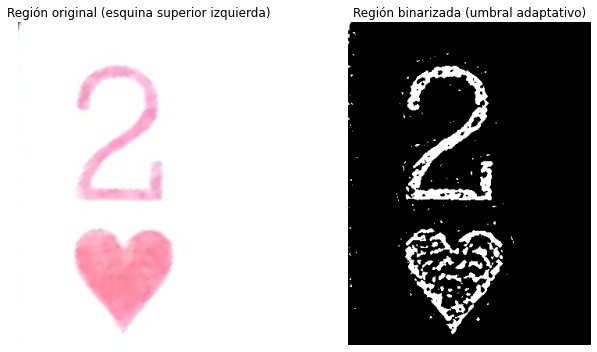

In [17]:
contornos = find_card_contours(preprocess_image(img))

if contornos:
    # Paso 1: Recorte y orientación de la carta
    warped = warp_card(img, contornos[0])
    oriented = correct_card_orientation(warped)

    # Paso 2: Extraer región de interés (esquina superior izquierda)
    h, w = oriented.shape[:2]
    region = oriented[0:int(h * 0.25), 0:int(w * 0.25)]  # Parte superior izquierda

    # Paso 3: Binarizar la región
    binaria = binarize_region(region)

    # Visualización
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Región original (esquina superior izquierda)")
    axs[0].axis("off")

    axs[1].imshow(binaria, cmap='gray')
    axs[1].set_title("Región binarizada (umbral adaptativo)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No se detectaron cartas.")


## 9. Suavizado morfológico
Esta función aplica operaciones morfológicas sobre una imagen binaria para mejorar su limpieza y legibilidad.

Pasos que realiza:

1. Cierre morfológico (`MORPH_CLOSE`): rellena pequeños huecos negros dentro de áreas blancas.
1. Apertura morfológica (`MORPH_OPEN`): elimina puntos blancos aislados que puedan considerarse ruido.

El resultado es una imagen binaria más limpia, ideal para una detección de contornos más precisa. Se utiliza comúnmente después de la binarización para mejorar la calidad de las regiones a analizar.

In [18]:
def morphological_smoothing(binary_img, kernel_size_open=(3, 3), kernel_size_close=(5, 5)):
    kernel_open = np.ones(kernel_size_open, np.uint8)
    kernel_close = np.ones(kernel_size_close, np.uint8)

    # 1. Tapar huecos negros en zonas blancas
    closed = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_close)

    # 2. Quitar puntitos blancos sueltos
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)

    return opened

En este ejemplo tomamos la región binarizada de la carta orientada y aplicamos la función morphological_smoothing para eliminar imperfecciones

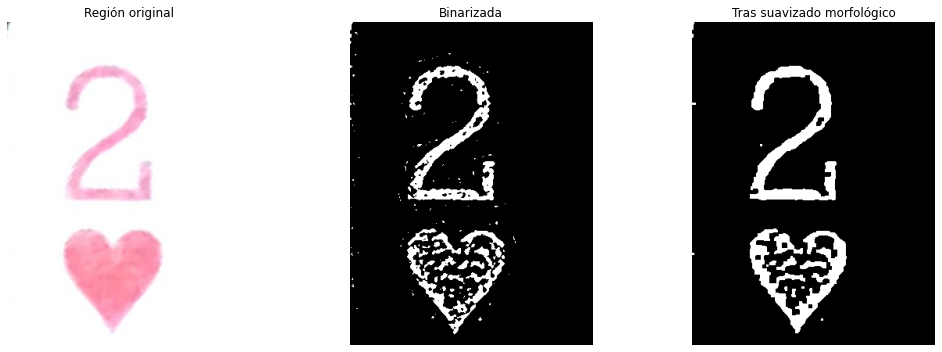

In [19]:
contornos = find_card_contours(preprocess_image(img))

if contornos:
    # Recortar y orientar carta
    warped = warp_card(img, contornos[0])
    oriented = correct_card_orientation(warped)

    # Extraer región del valor (esquina sup. izq.)
    h, w = oriented.shape[:2]
    region = oriented[0:int(h * 0.25), 0:int(w * 0.25)]

    # Binarizar región
    binaria = binarize_region(region)

    # Aplicar suavizado morfológico
    suavizada = morphological_smoothing(binaria)

    # Visualizar resultado
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Región original")
    axs[0].axis("off")

    axs[1].imshow(binaria, cmap="gray")
    axs[1].set_title("Binarizada")
    axs[1].axis("off")

    axs[2].imshow(suavizada, cmap="gray")
    axs[2].set_title("Tras suavizado morfológico")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No se detectaron cartas.")


## 10. Extracción del número y palo de la carta

Esta función se encarga de identificar y extraer la región donde se encuentra el número (rango) y el palo de la carta, generalmente ubicados en la esquina superior izquierda.

Pasos que realiza:

1. Se recorta una región de interés (ROI) desde la esquina superior izquierda de la carta. Esta región cubre aproximadamente el 25% de la altura y el 15% del ancho de la imagen. Estos valores pueden ajustarse si es necesario.
1. Se convierte la región a escala de grises, se mejora su contraste y se binariza usando un umbral adaptativo.
1. Se aplica suavizado morfológico para limpiar la imagen.
1. Se detectan contornos externos y se seleccionan los dos más grandes, asumiendo que corresponden al número y al palo.
1. Se ordenan los contornos de arriba hacia abajo (por coordenada vertical), y cada uno se recorta y redimensiona:
1. El primer contorno se considera el número.
1. El segundo contorno se considera el palo.
1. Si se encuentra exactamente un número y un palo, ambos se devuelven como imágenes separadas. En caso contrario, se devuelve `None`.
1. Si `debug=True`, se muestran visualizaciones del ROI, la binarización y las regiones recortadas del número y palo para facilitar la depuración.

In [20]:
def extract_number_suit_region(card_img, debug=False):
    h, w = card_img.shape[:2]

    #Recorte desde la esquina superior izquierda
    roi = card_img[0:int(h * 0.25), 0:int(w * 0.15)]  # zona donde aparece número y palo

    if debug:
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        plt.title("ROI (Esquina superior izquierda)")
        plt.axis("off")
        plt.show()

    #Preprocesado y binarización
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    bin_roi = binarize_region(gray_roi, block_size=31, C=2, blur_ksize=5, use_clahe=True)
    bin_roi = morphological_smoothing(bin_roi)

    #Buscar contornos externos
    contours, _ = cv2.findContours(bin_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #FILTRAR: ignorar contornos muy pequeños (ruido)
    filtered_contours = [c for c in contours if cv2.contourArea(c) > 80]

    if debug:
        print(f"Contornos totales: {len(contours)} | Filtrados: {len(filtered_contours)}")
        drawn = roi.copy()
        cv2.drawContours(drawn, filtered_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Contornos Filtrados (Verde)")
        plt.axis("off")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.imshow(bin_roi, cmap="gray")
        plt.title("Binarización Final")
        plt.axis("off")
        plt.show()

    #Elegimos los 2 contornos más grandes
    filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:2]
    filtered_contours = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[1])  # orden por Y

    ranksuit = []
    _rank = None

    for i, cnt in enumerate(filtered_contours):
        x, y, w_cnt, h_cnt = cv2.boundingRect(cnt)
        x2, y2 = x + w_cnt, y + h_cnt
        crop = roi[y:y2, x:x2]

        if i == 0:  # Rank (número)
            crop = cv2.resize(crop, (70, 125), interpolation=cv2.INTER_AREA)
            _rank = crop
        else:  # Suit (palo)
            crop = cv2.resize(crop, (70, 100), interpolation=cv2.INTER_AREA)

            if debug and _rank is not None:
                r_vis = cv2.resize(_rank, (70, 100))
                s_vis = cv2.resize(crop, (70, 100))
                joined = np.concatenate((r_vis, s_vis), axis=1)
                joined = cv2.resize(joined, (250, 200))
                plt.imshow(cv2.cvtColor(joined, cv2.COLOR_BGR2RGB))
                plt.title("Número y Palo")
                plt.show()

        ranksuit.append(crop)

    if len(ranksuit) != 2:
        return None, None

    return ranksuit[0], ranksuit[1]

En el código de abajo podemos ver un ejemplo del funcionamiento de la función encargada de extraer el número y el palo de una carta:

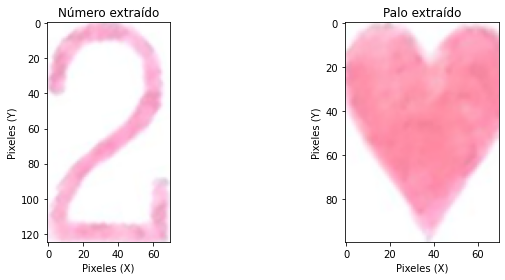

In [21]:
number_img, suit_img = extract_number_suit_region(oriented)

if number_img is not None and suit_img is not None:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(cv2.cvtColor(number_img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Número extraído")
    axs[0].set_xlabel("Pixeles (X)")
    axs[0].set_ylabel("Pixeles (Y)")

    axs[1].imshow(cv2.cvtColor(suit_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Palo extraído")
    axs[1].set_xlabel("Pixeles (X)")
    axs[1].set_ylabel("Pixeles (Y)")

    plt.tight_layout()
    plt.show()

## 11. Utilidades para preparar imágenes y plantillas

Estas funciones se encargan de normalizar, binarizar o redimensionar imágenes para que puedan ser comparadas correctamente con las plantillas.

- `resize_for_template(img, template_shape)`: redimensiona una imagen para que tenga el mismo tamaño que una plantilla.
- `normalize_for_template(img)`: aplica desenfoque y normalización de intensidad, útil en ciertos casos para estandarizar imágenes antes de comparar.
- `binarize_template(template)`: convierte una plantilla en imagen binaria mediante umbralado fijo. Asume que los elementos están sobre fondo blanco y no se invierte el resultado.

In [22]:
def resize_for_template(img, template_shape):
    return cv2.resize(img, (template_shape[1], template_shape[0]), interpolation=cv2.INTER_AREA)

def normalize_for_template(img):
    blur = cv2.GaussianBlur(img, (3, 3), 0)
    norm = cv2.normalize(blur.astype('float32'), None, 0, 255, cv2.NORM_MINMAX)
    return norm.astype('uint8')

def binarize_template(template):
    gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY) if len(template.shape) == 3 else template
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # SIN _INV
    return binary

    return binary

## 12. Verificación de contenido en una región

La función region_has_rank_or_suit se utiliza para comprobar si una región (por ejemplo, una esquina de la carta) contiene información relevante como un número o un palo.

Para ello:

- Convierte la región a escala de grises.
- Calcula la desviación estándar de la intensidad (para medir variación).
- Cuenta la cantidad de píxeles "oscuros".

Devuelve `True` si la variación y la cantidad de píxeles oscuros superan ciertos umbrales, lo que indica que probablemente hay contenido gráfico en la región.

In [23]:
def region_has_rank_or_suit(roi, std_thresh=15, dark_thresh=80, min_dark_pixels=250, debug=False):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    std = np.std(gray)
    dark_pixels = np.sum(gray < dark_thresh)

    if debug:
        print(f"STD: {std:.2f}, Dark Pixels: {dark_pixels}")

    return std > std_thresh and dark_pixels > min_dark_pixels

STD: 20.75, Dark Pixels: 1


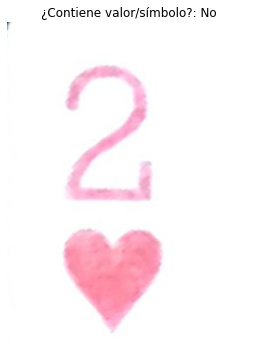

In [24]:
contornos = find_card_contours(preprocess_image(img))

if contornos:
    # Recortar y orientar la carta
    warped = warp_card(img, contornos[0])
    oriented = correct_card_orientation(warped)

    # Extraer región donde debería estar el número o palo
    h, w = oriented.shape[:2]
    region = oriented[0:int(h * 0.25), 0:int(w * 0.25)]

    # Verificar si contiene contenido útil
    contiene_info = region_has_rank_or_suit(region, debug=True)

    # Visualización
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    plt.title(f"¿Contiene valor/símbolo?: {'Sí' if contiene_info else 'No'}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No se detectaron cartas.")


## 13. Carga de plantillas de números y palos

La función `load_templates` carga todas las plantillas de números y palos desde la carpeta `Fotos/Plantillas`, dentro de esta carpeta tenemos dos plantillas distintas que son usadas en las funciones correspondientes.

- Busca todos los archivos `.jpg` cuyo nombre comience con el nombre del número o palo (`Ace`, `Two`, `Clubs`, etc.).
- Cada plantilla se carga en escala de grises y se almacena en un diccionario con su nombre como clave.

Devuelve dos diccionarios:

- `number_templates`: para comparar números.
- `suit_templates`: para comparar palos.

In [25]:
def load_templates():
    numbers = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
    suits = ['Clubs','Diamonds','Hearts','Spades']

    number_templates = {}
    suit_templates = {}

    for n in numbers:
        pattern = f'Fotos/Plantillas/{n}*.jpg'
        matches = glob.glob(pattern)
        number_templates[n] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    for s in suits:
        pattern = f'Fotos/Plantillas/{s}*.jpg'
        matches = glob.glob(pattern)
        suit_templates[s] = [cv2.imread(m, 0) for m in matches if cv2.imread(m, 0) is not None]

    return number_templates, suit_templates

## 14. Comparación de una región con plantillas

La función `match_template` compara una región de una carta (como el número o el palo) con un conjunto de plantillas precargadas.

Pasos que realiza:

1. Binariza y suaviza la región objetivo.
1. Para cada plantilla del conjunto:
- Se binariza.
- Se redimensiona la región objetivo al tamaño de la plantilla.
- Se calcula una correlación normalizada (`cv2.matchTemplate`) para comparar similitud.
3. Se selecciona la plantilla con mayor puntuación como resultado.

Opcionalmente, se pueden mostrar las imágenes comparadas si `debug=True`.

In [26]:
def match_template(region, templates, debug=False):
    # Preprocesamiento de la región
    bin_roi = binarize_region(region, block_size=31, C=2, blur_ksize=5, use_clahe=True)
    binary = morphological_smoothing(bin_roi)

    best_name, best_score = "Desconocido", -1

    for name, template_list in templates.items():
        for template in template_list:
            if template is None:
                continue

            # Preprocesamiento de la plantilla
            templ_bin = binarize_template(template)

            # Redimensionar la región binaria al tamaño de la plantilla
            resized = cv2.resize(binary, (templ_bin.shape[1], templ_bin.shape[0]), interpolation=cv2.INTER_AREA)

            # Correlación por plantilla
            result = cv2.matchTemplate(resized, templ_bin, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, _ = cv2.minMaxLoc(result)

            # Visualización en modo debug
            if debug:
                print(f"{name}: score = {max_val:.4f}")

                plt.figure(figsize=(12, 4))

                # 1. Región binaria
                plt.subplot(1, 3, 1)
                plt.imshow(resized, cmap='gray')
                plt.title("Región binarizada")
                plt.axis("off")

                # 2. Plantilla binaria
                plt.subplot(1, 3, 2)
                plt.imshow(templ_bin, cmap='gray')
                plt.title(f"Plantilla: {name}")
                plt.axis("off")

                # 3. Mapa de correlación
                plt.subplot(1, 3, 3)
                plt.imshow(result, cmap='hot')
                plt.colorbar()
                plt.title(f"Mapa de correlación\nScore = {max_val:.4f}")
                plt.axis("off")

                plt.tight_layout()
                plt.savefig("paso7_plantilla.png")
                plt.show()

            # Guardar mejor resultado
            if max_val > best_score:
                best_name, best_score = name, max_val

    return best_name

En el ejemplo siguiente podemos ver como se hace el match template entre la carta detectada y la plantilla, previamente cargada mediante la función load_templates:

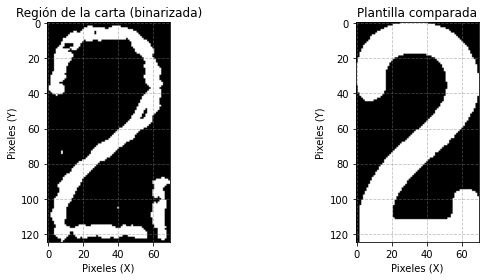

In [27]:
number_templates, suit_templates = load_templates()
templ_bin = binarize_template(number_templates['Two'][0])
resized = cv2.resize(binarize_region(number_img), (templ_bin.shape[1], templ_bin.shape[0]))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(resized, cmap='gray')
axs[0].set_title("Región de la carta (binarizada)")
axs[0].grid(True, linestyle='--', color='gray', alpha=0.5)
axs[0].set_xlabel("Pixeles (X)")
axs[0].set_ylabel("Pixeles (Y)")

axs[1].imshow(templ_bin, cmap='gray')
axs[1].set_title("Plantilla comparada")
axs[1].grid(True, linestyle='--', color='gray', alpha=0.5)
axs[1].set_xlabel("Pixeles (X)")
axs[1].set_ylabel("Pixeles (Y)")

plt.tight_layout()
plt.show()

## 15. Ejecución principal del sistema (`main`)

Esta función coordina todo el flujo del reconocimiento:

1. Carga la imagen desde disco.
1. La preprocesa para detectar bordes.
1. Encuentra los contornos de las cartas.
1. Para cada carta detectada:
- Se corrige la perspectiva (warp).
- Se rota para asegurar la orientación correcta.
- Se valida la proporción.
- Se extraen las regiones del número y el palo.
- Se comparan estas regiones con plantillas para identificar la carta.

Permite activar modo `debug` para visualizar cada paso.

Devuelve el número y el palo detectados de la primera carta válida encontrada en la imagen.

In [53]:
def main(path, debug=False, draw_predictions=True, show_result=True):
    image = cv2.imread(path)
    original = image.copy()

    edges = preprocess_image(image)
    if debug:
        plt.figure(figsize=(8, 6))
        plt.imshow(edges, cmap='gray')
        plt.title("Imagen Binarizada para Contornos")
        plt.axis('off')
        plt.show()
    card_contours = find_card_contours(edges)
     # Visualizar contornos
    if debug:
        drawn = image.copy()
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.show()

        drawn = np.zeros_like(image)

        # ✅ Dibujar contornos detectados en verde
        cv2.drawContours(drawn, card_contours, -1, (0, 255, 0), 2)

        # 🎨 Mostrar
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas (Sobre Fondo Negro)")
        plt.axis("off")
        plt.show()

    if debug:
        print(f"🟢 Cartas detectadas: {len(card_contours)}")

    number_templates, suit_templates = load_templates()
    detected_cards = []

    for i, contour in enumerate(card_contours):
        warped = warp_card(image, contour)
        if warped is None:
            if debug:
                print(f"❌ Contorno {i} no pudo ser transformado.")
            continue

        warped = correct_card_orientation(warped, debug)
        if warped is None or not is_valid_card_proportion(warped, debug=debug):
            if debug:
                print(f"⚠️ Contorno {i} descartado por proporción.")
            continue

        if debug:
            plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
            plt.title("Carta warped")
            plt.show()
            
        number_region, suit_region = extract_number_suit_region(warped, debug=debug)
        if debug:
            print("Template mathing:")
        if number_region is not None and suit_region is not None:
            number = match_template(number_region, number_templates, debug=debug)
            suit = match_template(suit_region, suit_templates, debug=debug)
            detected_cards.append((contour, number, suit))

            if debug:
                print(f"🃏 Carta {i + 1}: {number} de {suit}")
        else:
            if debug:
                print(f"❌ Carta {i + 1}: no se pudo extraer número y palo.")

    # 🔤 Dibujar los resultados sobre la imagen original
    if draw_predictions:
        for i, (contour, number, suit) in enumerate(detected_cards):
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
            else:
                cx, cy = contour[0][0]

            label = f"{number} of {suit}"
            # Obtener tamaño del texto (retorna tamaño y línea base)
            (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 5, 7)

            # Ajustar el punto de inicio para centrar horizontalmente
            text_x = cx - text_width // 2
            text_y = cy + text_height // 2  # Puedes ajustar el Y si quieres moverlo arriba/abajo
            
            cv2.putText(original, label, (text_x-3, text_y-3),
            cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 10, cv2.LINE_AA)
            
            # Dibujar texto centrado
            cv2.putText(original, label, (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 7, cv2.LINE_AA)
            cv2.drawContours(original, [contour], -1, (0, 255, 0), 2)

    # Mostrar la imagen final
    if show_result:
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title("Cartas Detectadas")
        plt.axis("off")
        plt.show()

    # Devolver resultados en forma de lista
    return [(number, suit) for _, number, suit in detected_cards]


## Experimentaciones

Este código establece la estructura básica para la detección de cartas en imágenes. Se definen los valores y palos de las cartas mediante diccionarios, y una función para extraer información del nombre de cada carta. Esto servirá como base para la experimentación y el procesamiento posterior de las cartas detectadas.

In [30]:
import os
import re
import cv2
import numpy as np

suits = {
    "Clubs": "C",
    "Diamonds": "D",
    "Hearts": "H",
    "Spades": "S"
}

numbers = {
    "Ace": "A",
    "Two": "2",
    "Three": "3",
    "Four": "4",
    "Five": "5",
    "Six": "6",
    "Seven": "7",
    "Eight": "8",
    "Nine": "9",
    "Ten": "10",
    "Jack": "J",
    "Queen": "Q",
    "King": "K"
}

def extraer_datos(nombre):
    match = re.match(r"(\w+)([A-Z])", nombre)
    if match:
        numero = match.group(1)
        letra = match.group(2)
        return numero, letra
    return None, None


Primero vamos a probar el código con una carpeta de fotos simples

In [35]:
succession = []

# Generar combinaciones: cada carta en 2 posiciones
for number_name, number_symbol in numbers.items():
    for suit_name, suit_symbol in suits.items():
        for i in range(1):
            filename = f"{number_symbol}{suit_symbol}.png"
            ruta_completa = os.path.join("Fotos", "fotos_sencillas", filename)

            if not os.path.exists(ruta_completa):
                print(f"⚠️ Archivo no encontrado: {ruta_completa}")
                continue

            print("Archivo:", filename)
            print("-" * 100)

            resultados = main(ruta_completa, debug=False, draw_predictions=False, show_result=False)

            number_pred, suit_pred = extraer_datos(filename)
            expected_symbol = number_symbol + suit_symbol

            if not resultados:
                print("❌ No se detectaron cartas")
                succession.append(False)
            else:
                match_encontrado = False
                for number, suit in resultados:
                    if numbers.get(number) == number_symbol and suits.get(suit) == suit_symbol:
                        print(f"✅ Acierto: {number} of {suit}")
                        succession.append(True)
                        match_encontrado = True
                        break

                if not match_encontrado:
                    print(f"❌ Fallo: ninguna coincidencia para {expected_symbol}")
                    succession.append(False)

            print("=" * 100)

# Calcular totales
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

# Calcular porcentajes
porcentaje_aciertos = (aciertos / total) * 100
porcentaje_fallos = (fallos / total) * 100

print(f"\nResumen final:")
print(f"Aciertos: {aciertos} / {total} → {porcentaje_aciertos:.2f}%")
print(f"Fallos: {fallos} / {total} → {porcentaje_fallos:.2f}%")

Archivo: AC.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Clubs
Archivo: AD.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Diamonds
Archivo: AH.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Hearts
Archivo: AS.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Ace of Spades
Archivo: 2C.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Two of Clubs
Archivo: 2D.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Two of Diamonds
Archivo: 2H.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Two of Hearts
Arch

Archivo: 10C.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Ten of Clubs
Archivo: 10D.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Ten of Diamonds
Archivo: 10H.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Ten of Hearts
Archivo: 10S.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Ten of Spades
Archivo: JC.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Jack of Clubs
Archivo: JD.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Jack of Diamonds
Archivo: JH.png
----------------------------------------------------------------------------------------------------
✅ Acierto: Jack of Hear

Una vez comprobado el funcionamiento del código en las fotos simples, y conseguido el 100% de éxito, pasamos a probarlo con fotos más complejas donde la carta está en perspectiva y bajo distintas condiciones de luz

In [42]:
from tqdm import tqdm


succession = []

carpeta = os.path.join("Fotos", "fotos_complejas")
archivos = [f for f in os.listdir(carpeta) if f.lower().endswith(".jpg")]

for filename in tqdm(archivos, desc="Procesando imágenes"):
    ruta_completa = os.path.join(carpeta, filename)

    resultados = main(ruta_completa, debug=False, draw_predictions=False, show_result=False)

    # Asumimos que hay al menos una carta detectada
    if not resultados:
        succession.append(False)
        continue

    number, suit = resultados[0]  # ✅ Consideramos solo la primera carta detectada

    number_prediction, suit_prediction = extraer_datos(filename)

    if suit is None or number is None:
        succession.append(False)
    else:
        try:
            match_number = numbers[number]
            match_suit = suits[suit]

            if match_number == number_prediction and match_suit == suit_prediction:
                succession.append(True)
            else:
                succession.append(False)
        except KeyError:
            succession.append(False)

# === RESUMEN FINAL ===
total = len(succession)
aciertos = succession.count(True)
fallos = succession.count(False)

porcentaje_aciertos = (aciertos / total) * 100 if total > 0 else 0
porcentaje_fallos = (fallos / total) * 100 if total > 0 else 0

print(f"\nResumen final:")
print(f"Total imágenes: {total}")
print(f"Aciertos: {aciertos} ({porcentaje_aciertos:.2f}%)")
print(f"Fallos: {fallos} ({porcentaje_fallos:.2f}%)")


Procesando imágenes: 100%|█████████████████████████████████████████████████████████| 2055/2055 [10:15<00:00,  3.34it/s]


Resumen final:
Total imágenes: 2055
Aciertos: 1291 (62.82%)
Fallos: 764 (37.18%)


Ahora vamos a probar el funcionamiento del código con cartas sueltas para ver los pasos, primero con fotos de una carta y luego con fotos de varias cartas a la vez

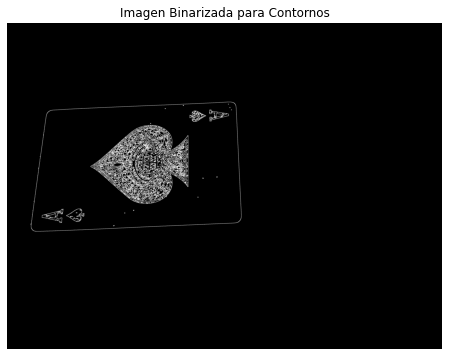

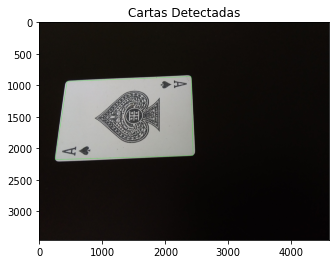

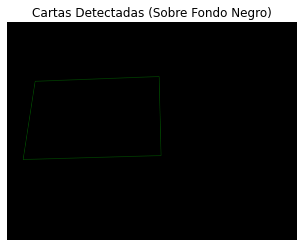

🟢 Cartas detectadas: 1
Dimensiones - Alto: 1254, Ancho: 2192
Rotando la carta 90° en sentido horario
[DEBUG] Dimensiones carta: 1254x2192 | Ratio: 1.75 | 0.19999999999999996 <= 1.75 <= 1.8
	Resultado:True


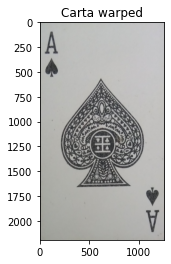

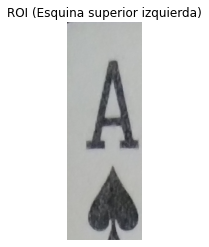

Contornos totales: 170 | Filtrados: 48


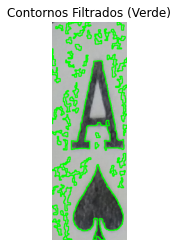

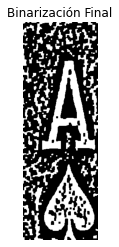

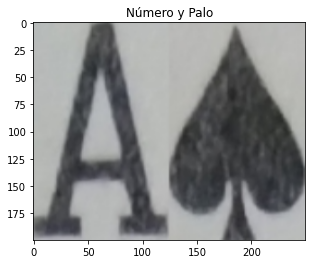

Template mathing:
Ace: score = 0.6761


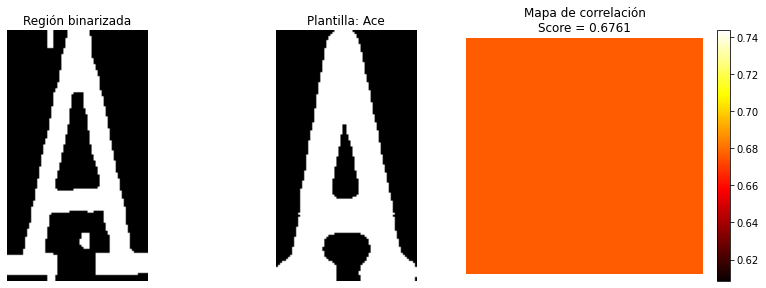

Ace: score = 0.7632


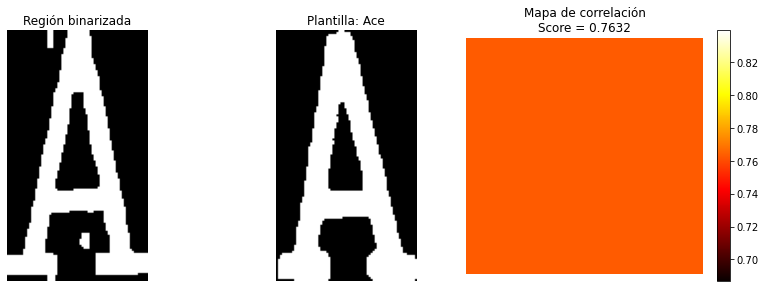

Two: score = 0.0318


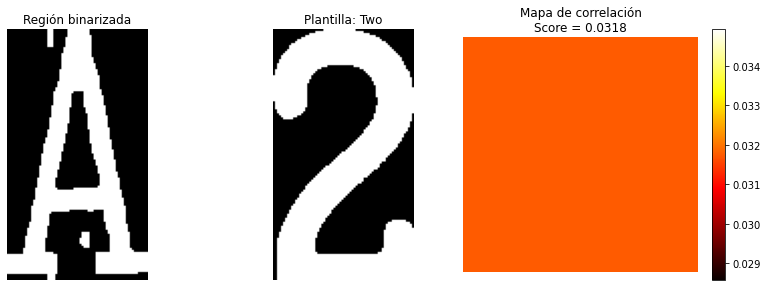

Two: score = 0.0335


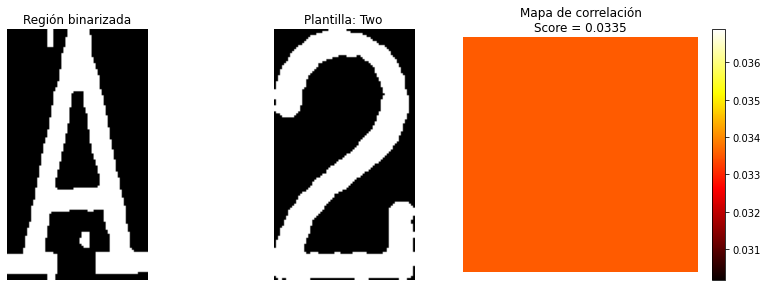

Three: score = 0.0849


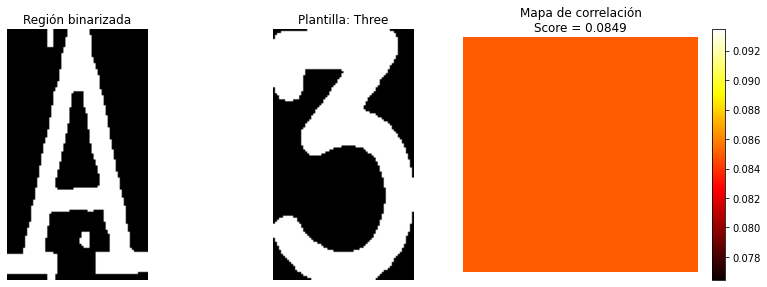

Three: score = -0.0384


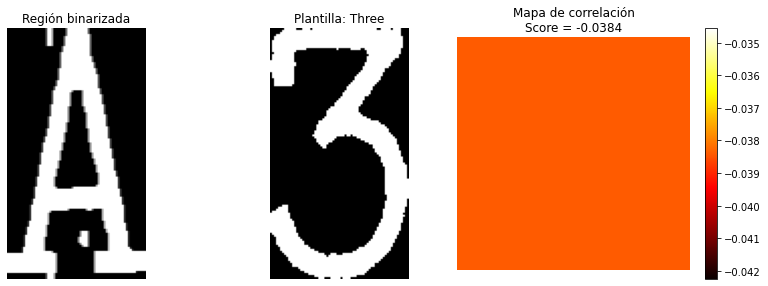

Four: score = 0.3484


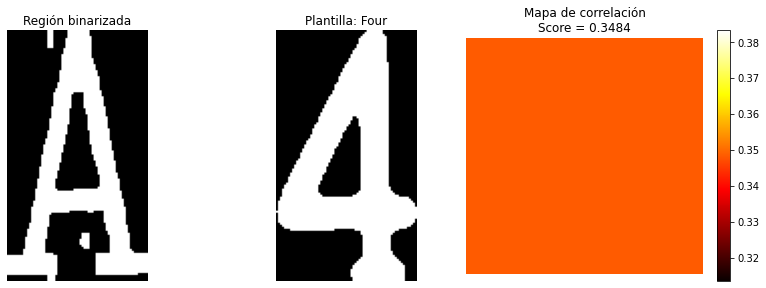

Four: score = 0.1883


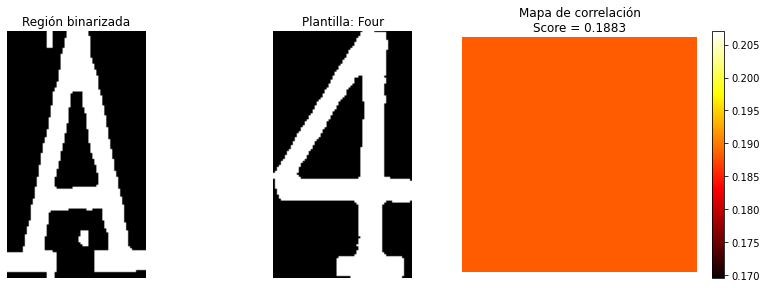

Five: score = -0.0590


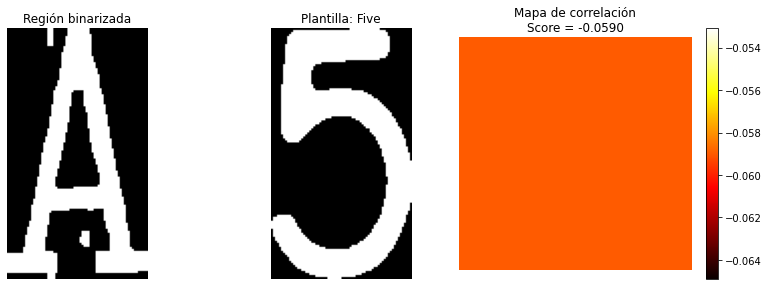

Five: score = -0.0790


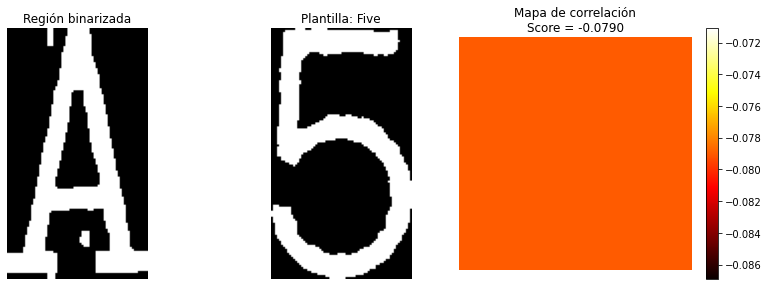

Six: score = -0.1326


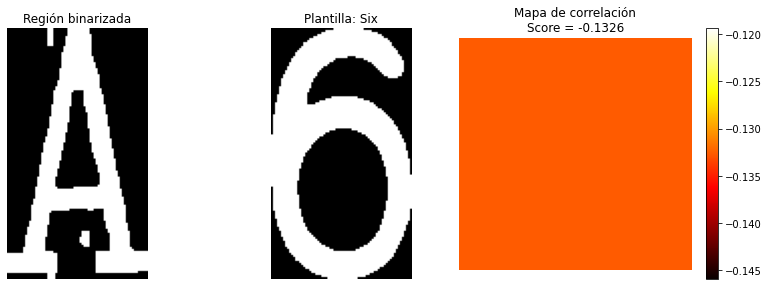

Six: score = -0.1146


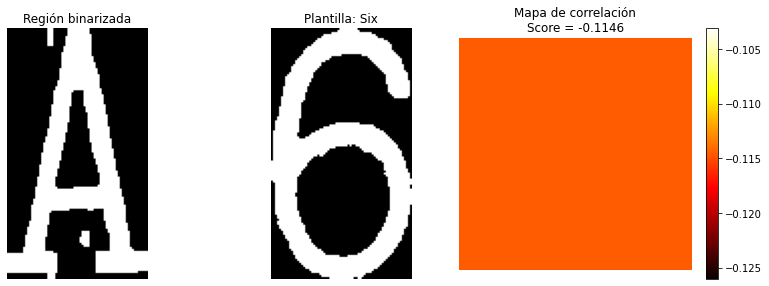

Seven: score = -0.1306


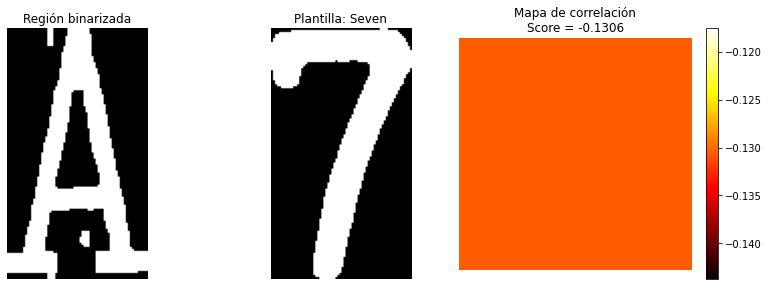

Seven: score = -0.1194


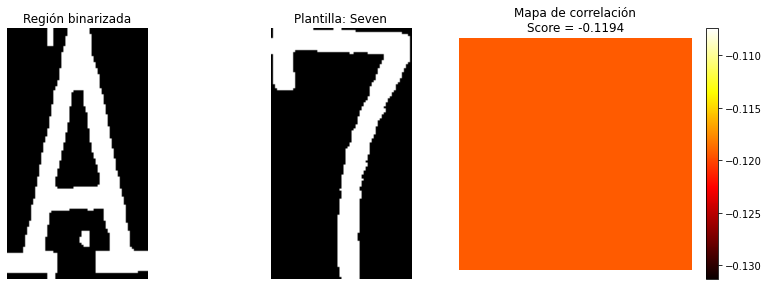

Eight: score = -0.1037


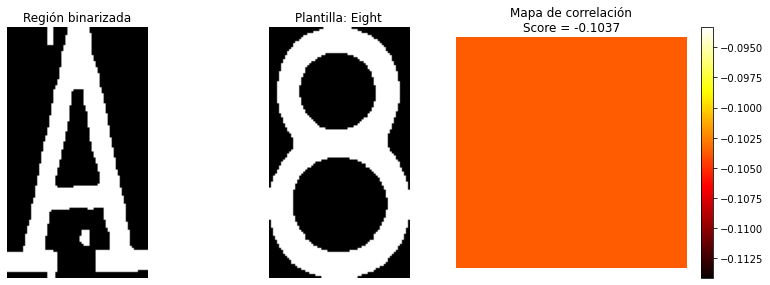

Eight: score = -0.1026


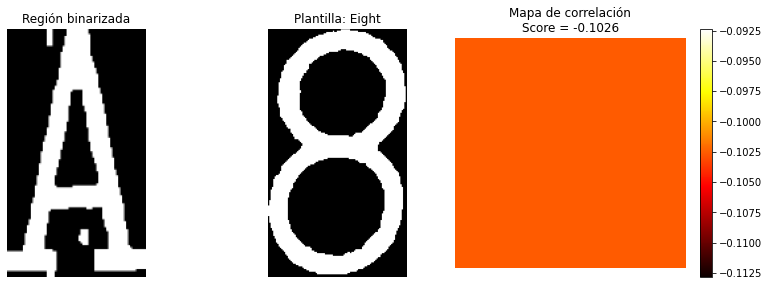

Nine: score = -0.0491


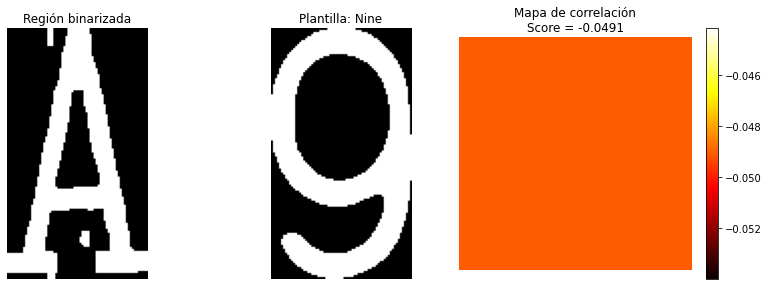

Nine: score = -0.1533


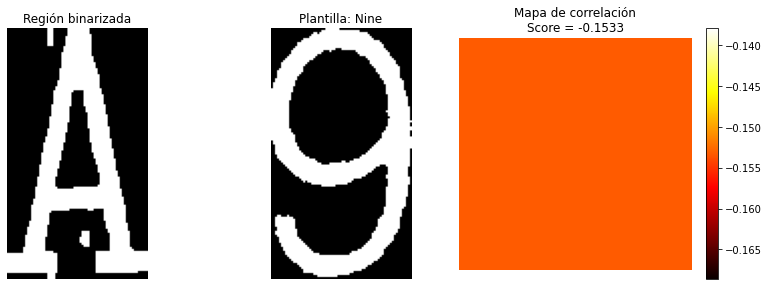

Ten: score = -0.2134


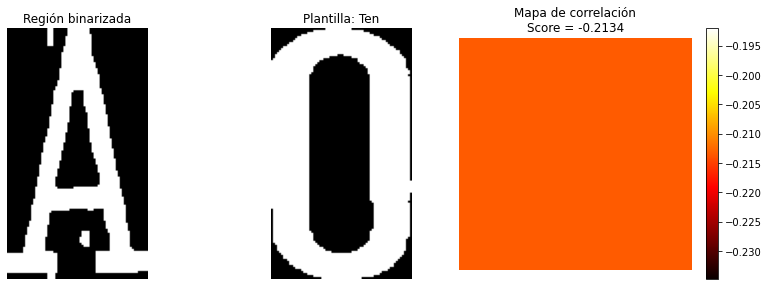

Ten: score = -0.2722


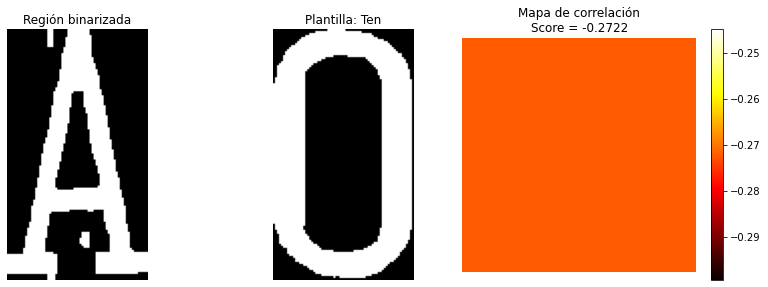

Jack: score = 0.1139


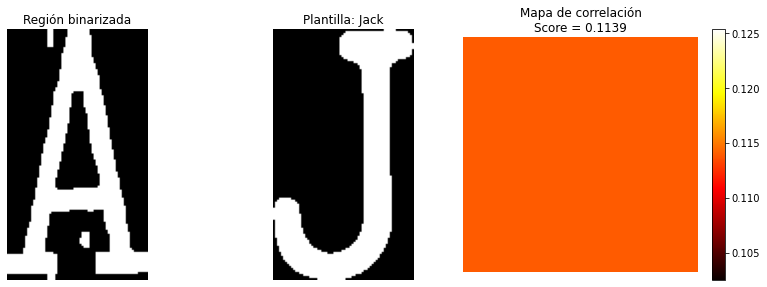

Jack: score = 0.0693


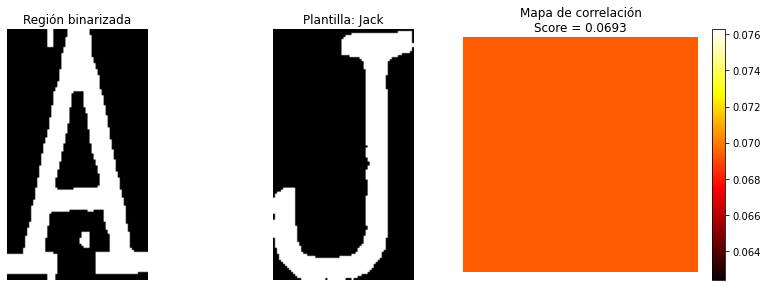

Queen: score = 0.2163


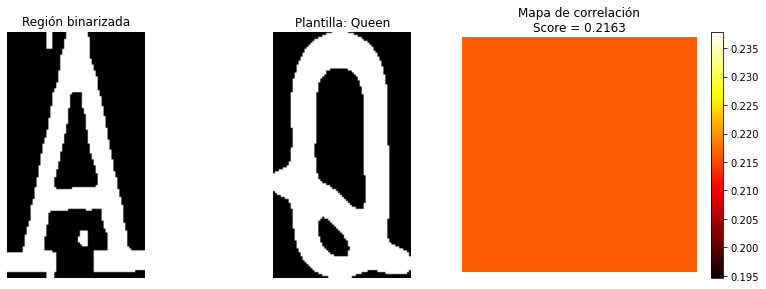

Queen: score = -0.1246


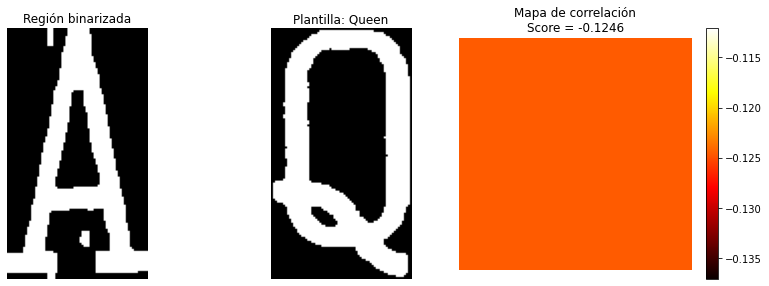

King: score = 0.1581


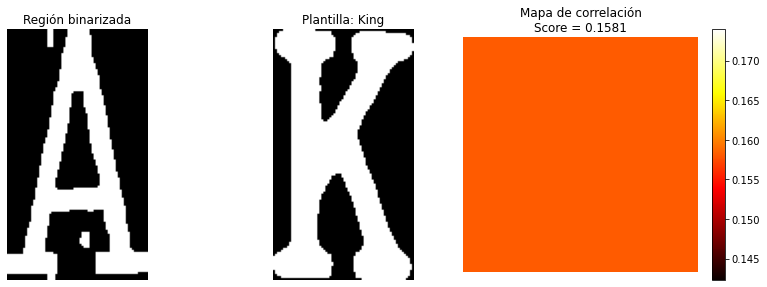

King: score = 0.1547


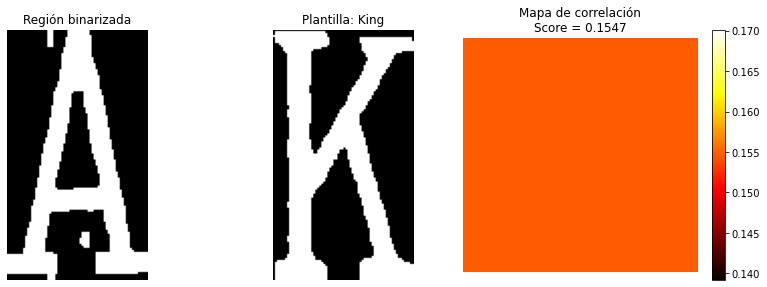

Clubs: score = 0.4619


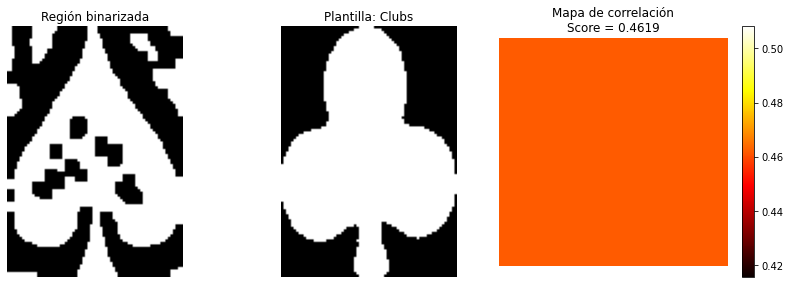

Clubs: score = 0.4611


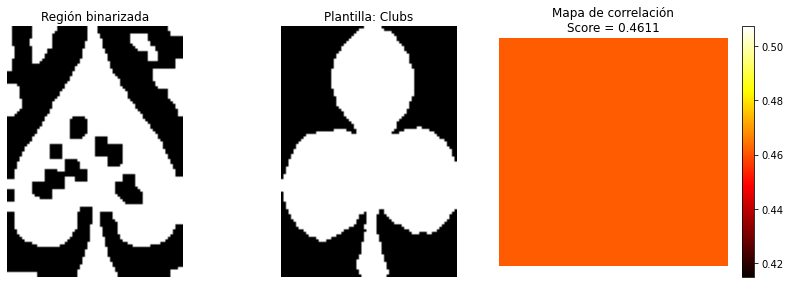

Diamonds: score = 0.2832


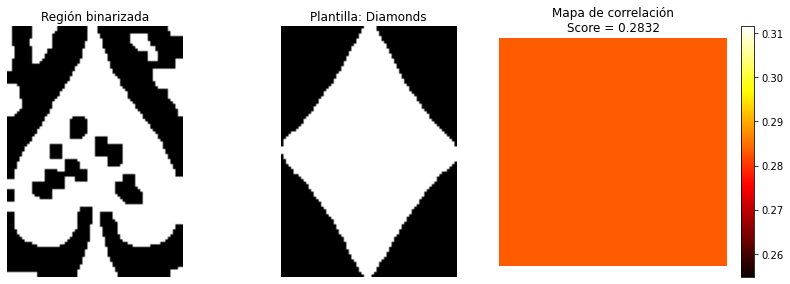

Diamonds: score = 0.3146


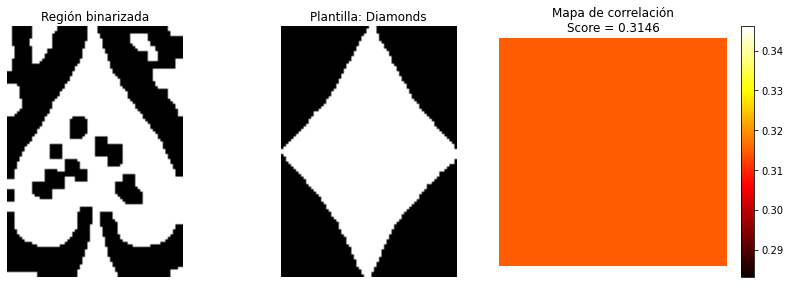

Hearts: score = 0.0734


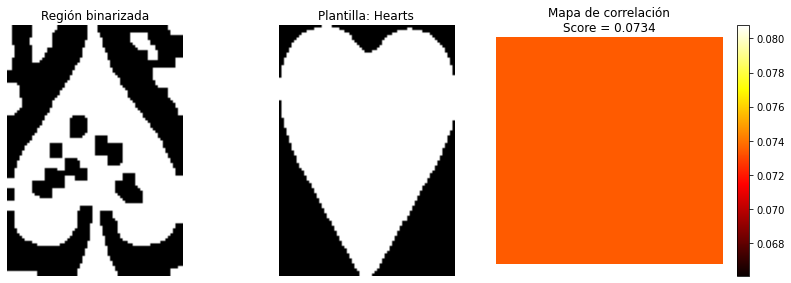

Hearts: score = 0.0227


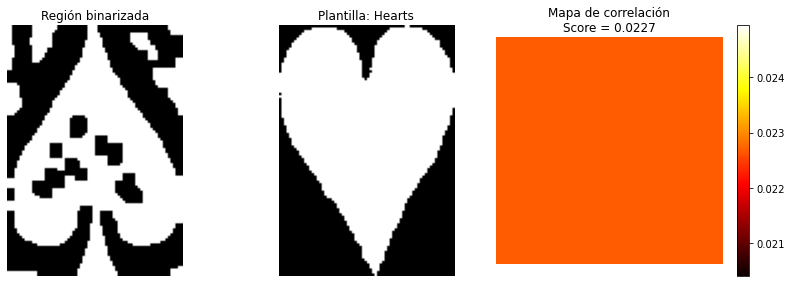

Spades: score = 0.4638


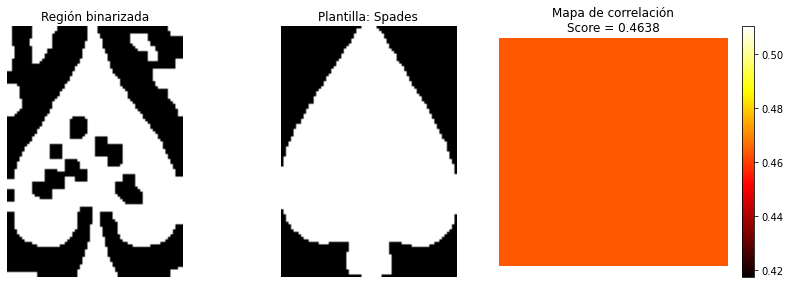

Spades: score = 0.5666


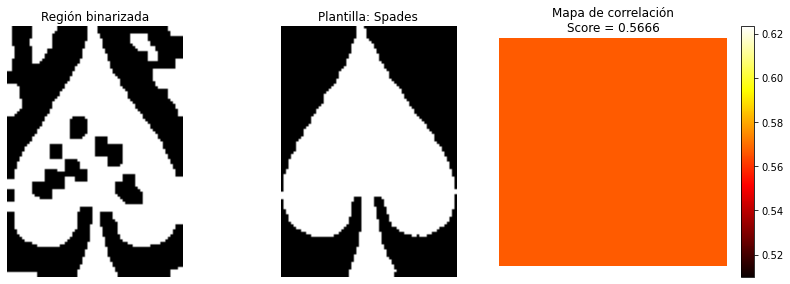

🃏 Carta 1: Ace de Spades


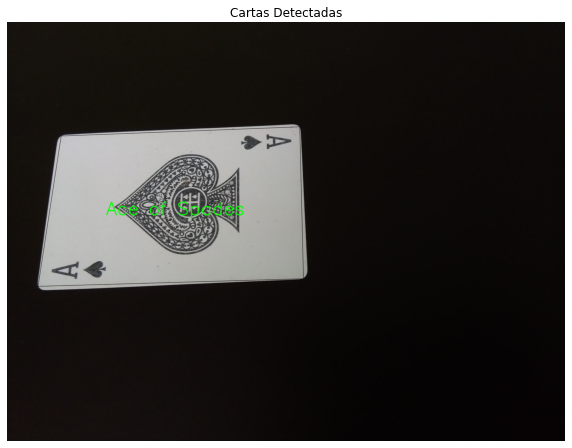

[('Ace', 'Spades')]

In [52]:
main("Fotos/fotos_complejas/AS0.jpg", debug=True)

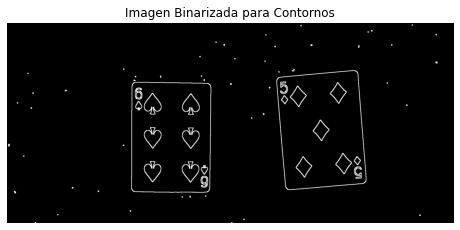

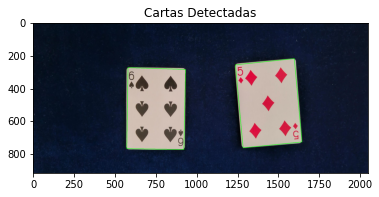

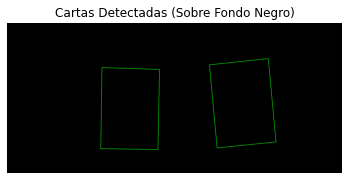

🟢 Cartas detectadas: 2
Dimensiones - Alto: 495, Ancho: 352
[DEBUG] Dimensiones carta: 352x495 | Ratio: 1.41 | 0.19999999999999996 <= 1.41 <= 1.8
	Resultado:True


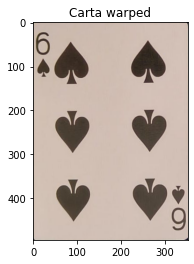

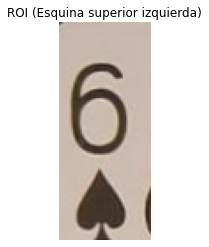

Contornos totales: 10 | Filtrados: 2


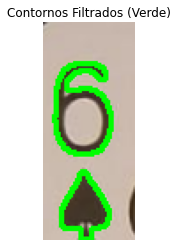

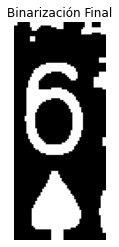

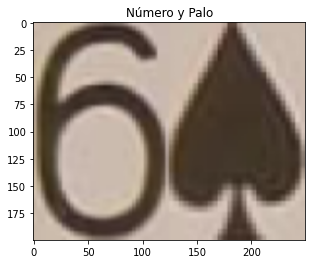

Template mathing:
Ace: score = -0.1027


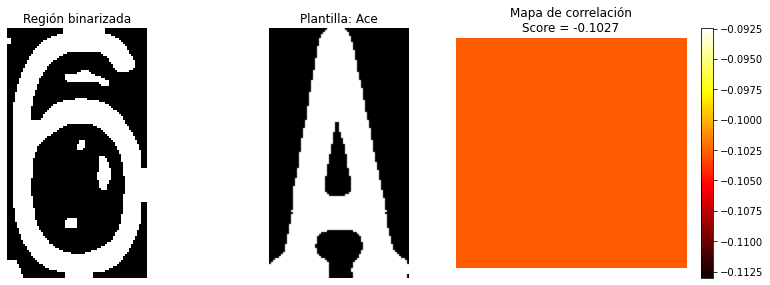

Ace: score = -0.0867


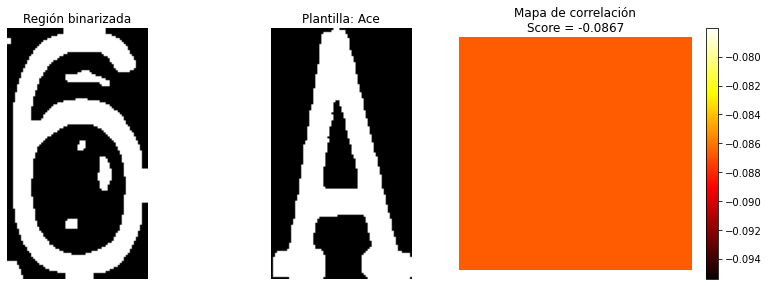

Two: score = 0.0755


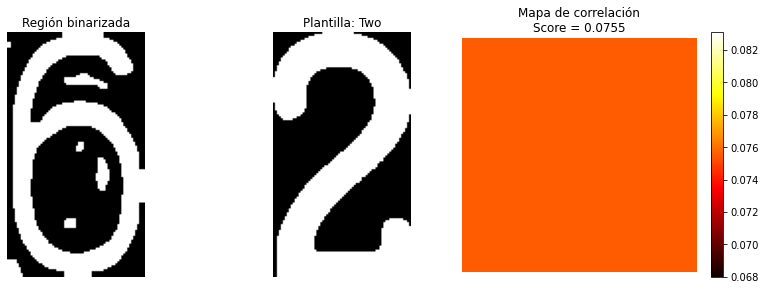

Two: score = 0.1708


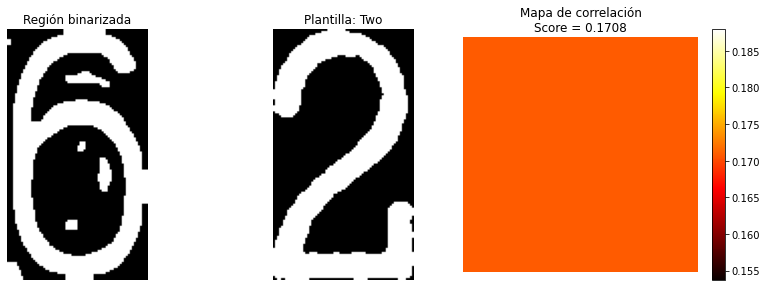

Three: score = 0.3799


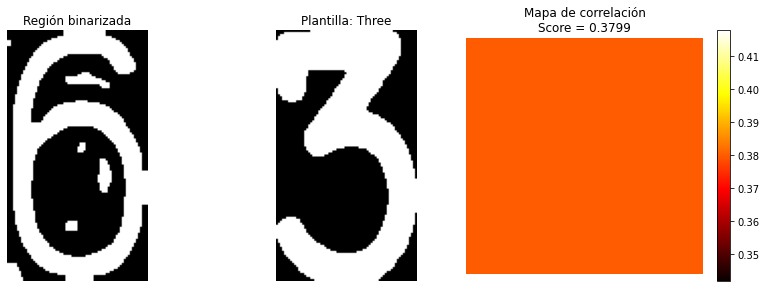

Three: score = 0.3827


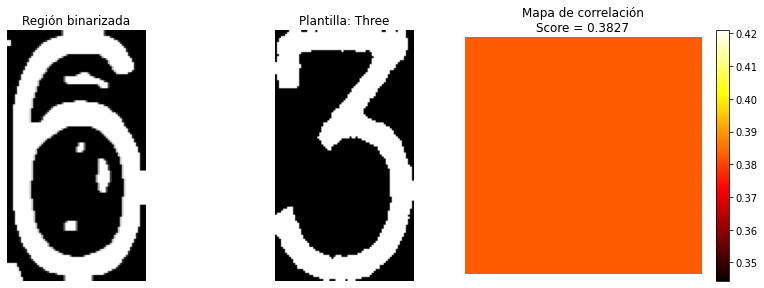

Four: score = 0.0137


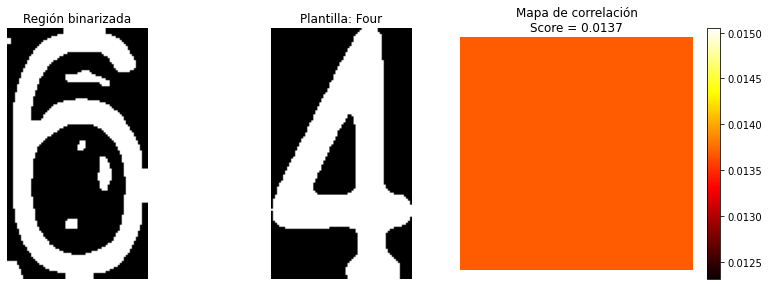

Four: score = 0.0809


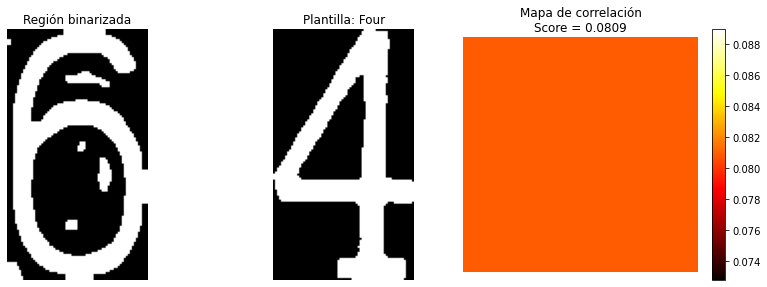

Five: score = 0.5065


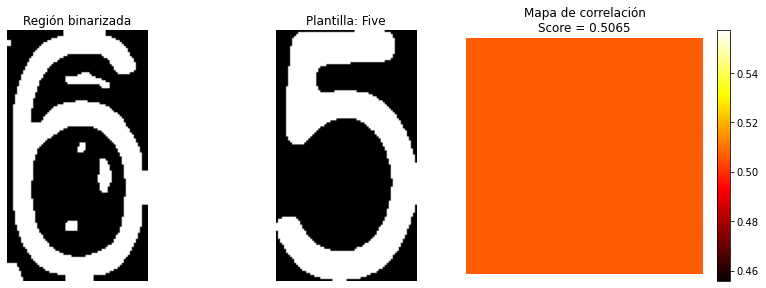

Five: score = 0.5145


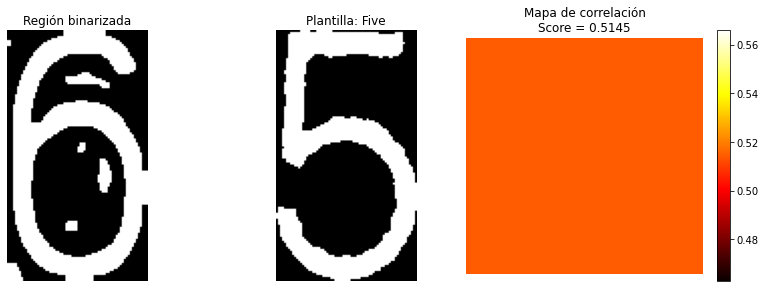

Six: score = 0.7110


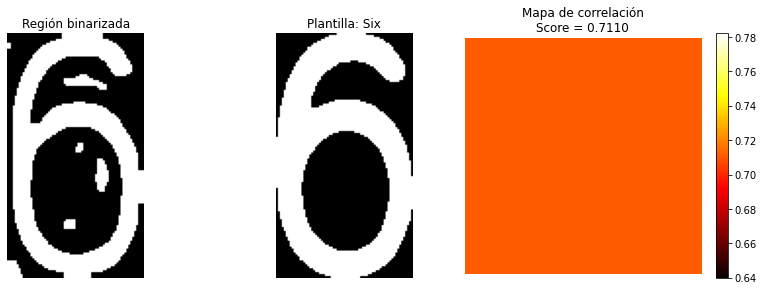

Six: score = 0.5418


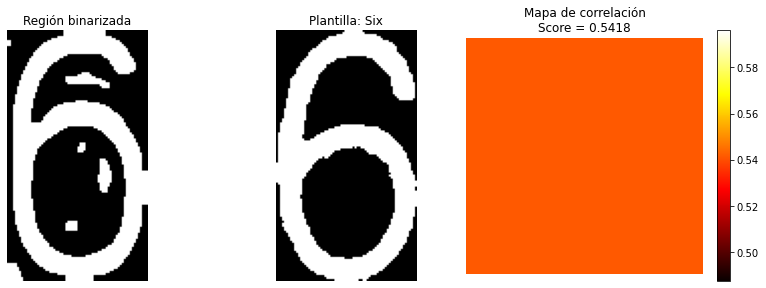

Seven: score = -0.0518


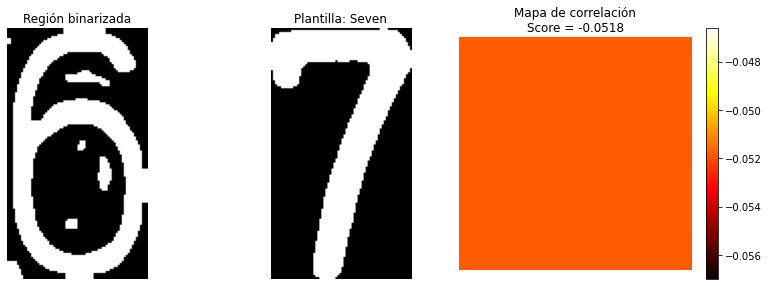

Seven: score = -0.0342


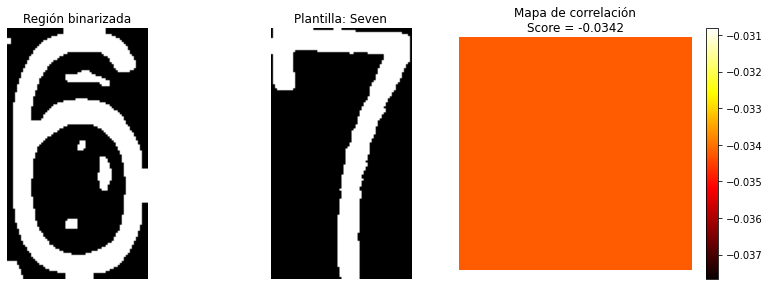

Eight: score = 0.4341


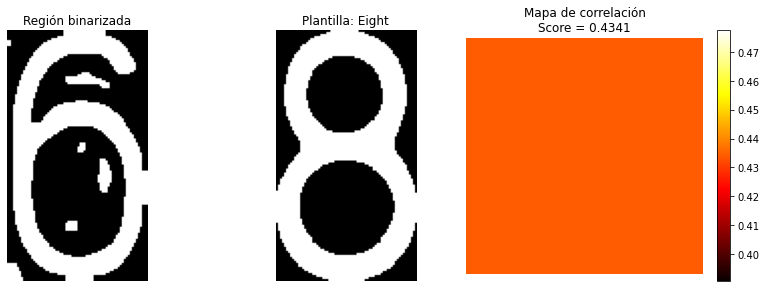

Eight: score = 0.4085


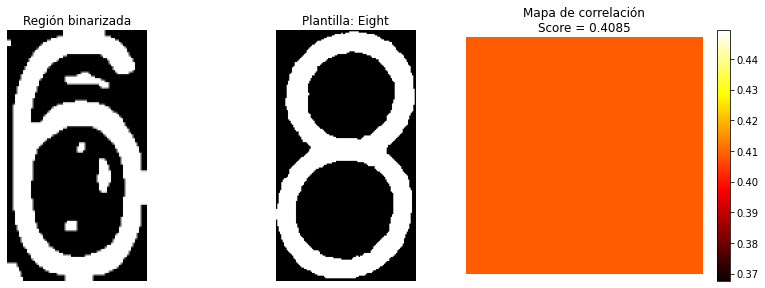

Nine: score = 0.3455


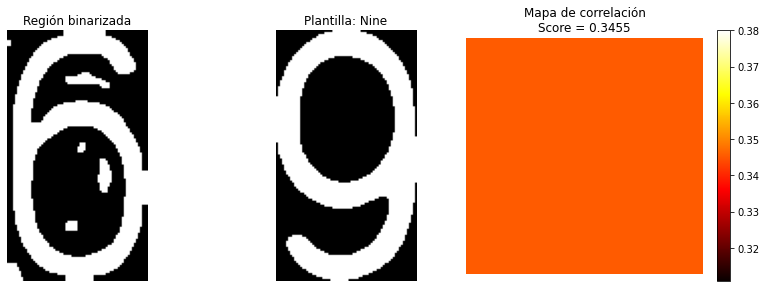

Nine: score = 0.3179


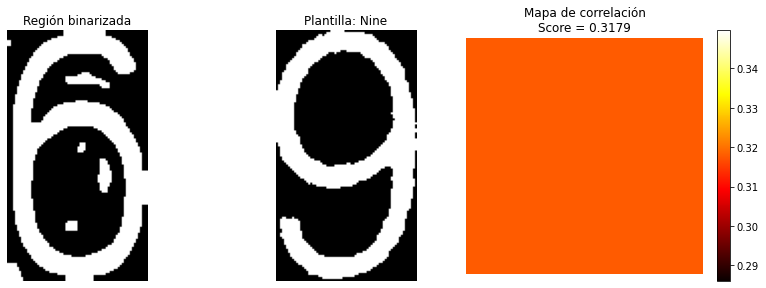

Ten: score = 0.3841


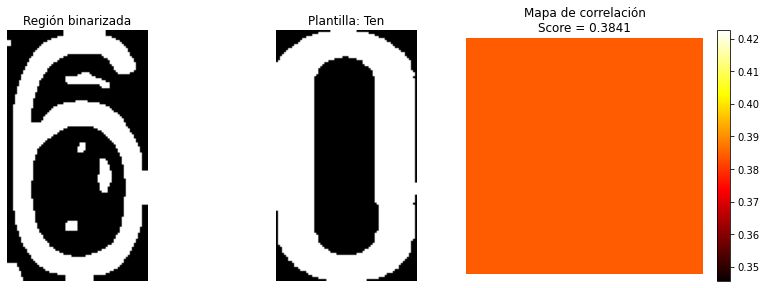

Ten: score = 0.4579


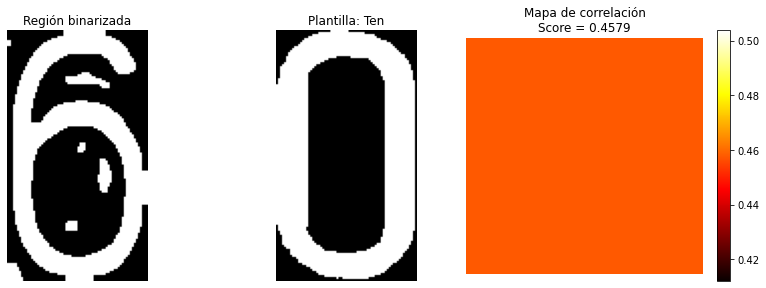

Jack: score = 0.1316


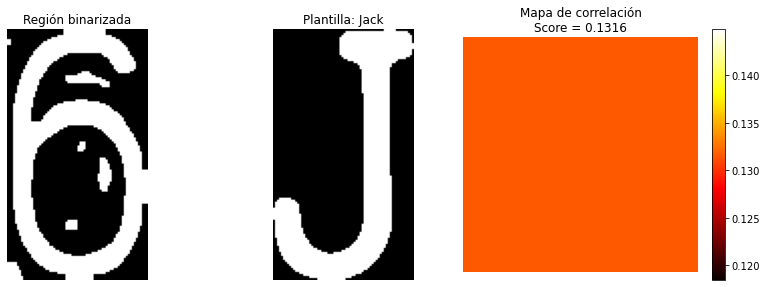

Jack: score = 0.1159


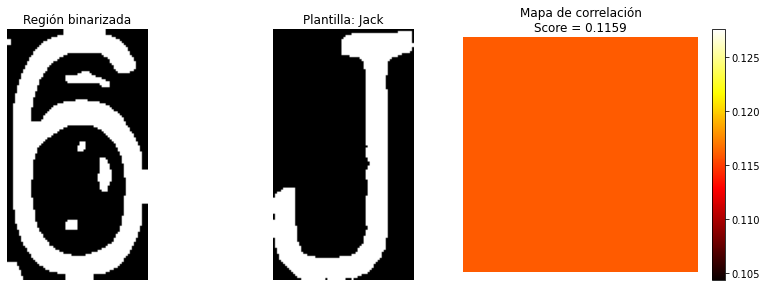

Queen: score = 0.1210


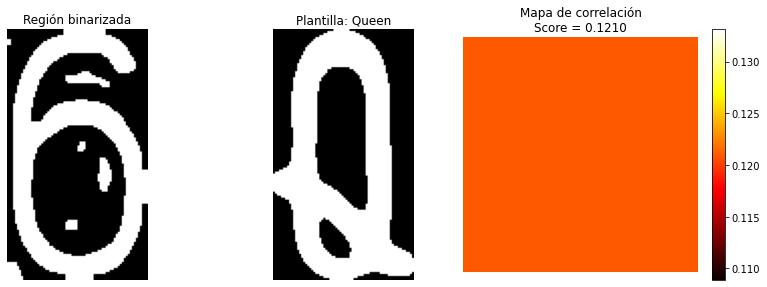

Queen: score = 0.1649


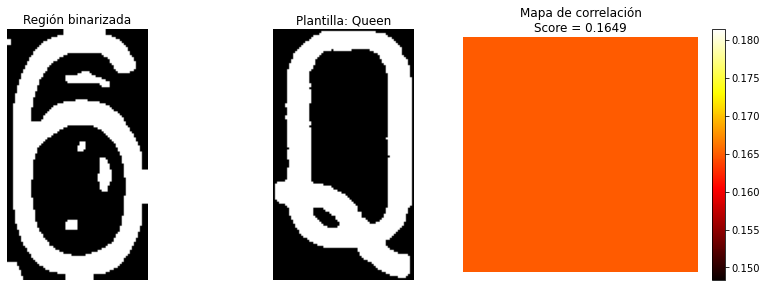

King: score = 0.0208


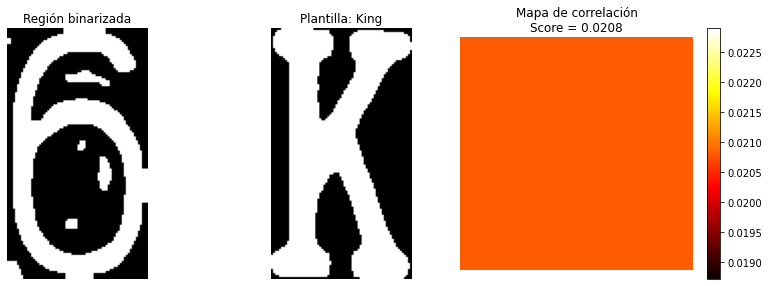

King: score = 0.0565


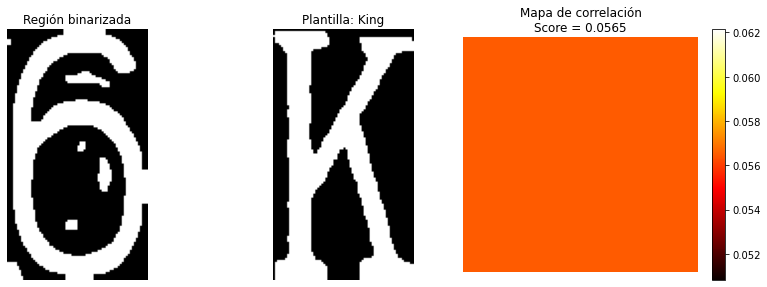

Clubs: score = 0.4982


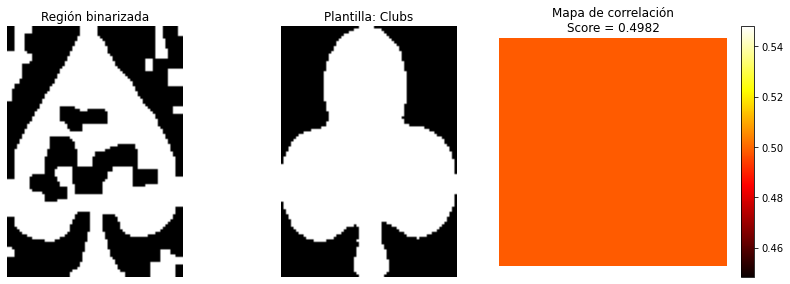

Clubs: score = 0.4686


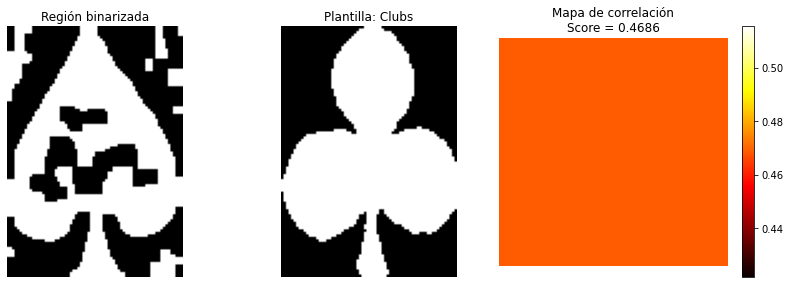

Diamonds: score = 0.3412


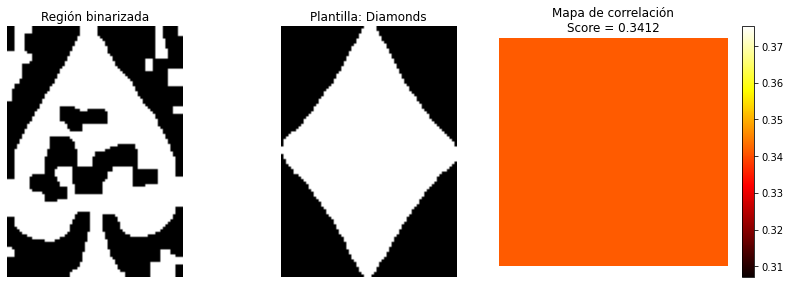

Diamonds: score = 0.3202


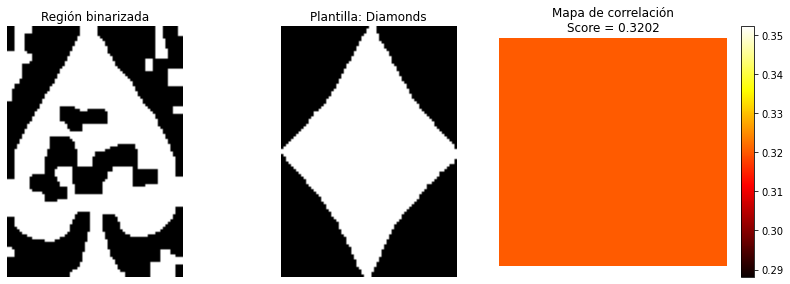

Hearts: score = 0.0579


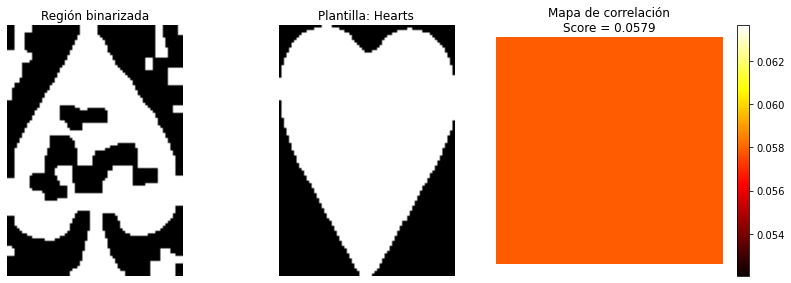

Hearts: score = 0.0232


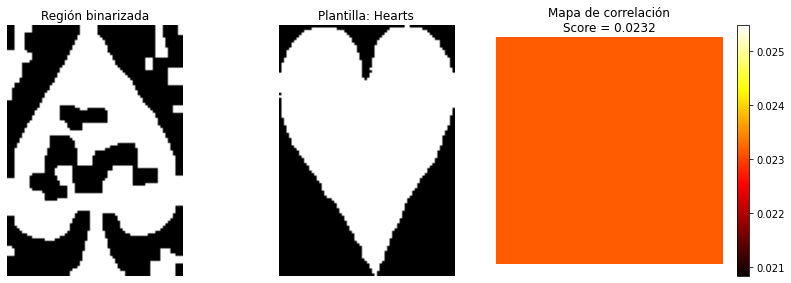

Spades: score = 0.5118


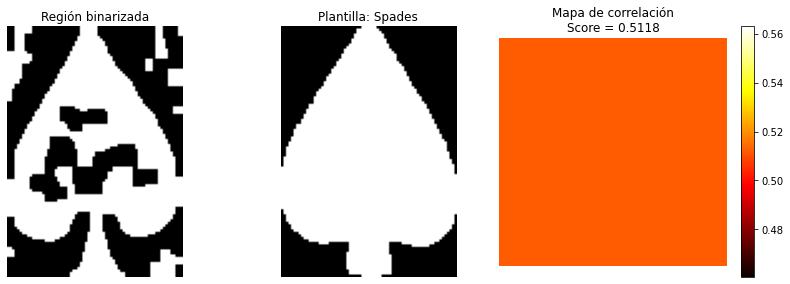

Spades: score = 0.5399


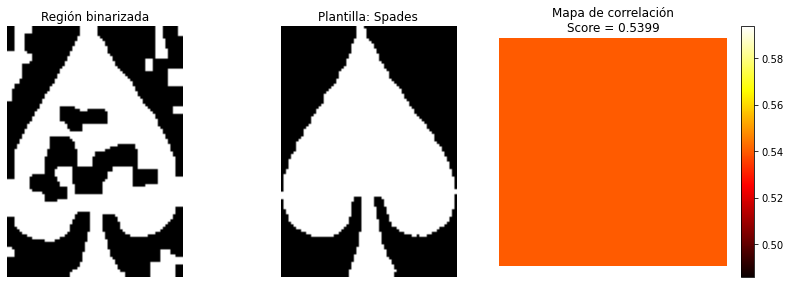

🃏 Carta 1: Six de Spades
Dimensiones - Alto: 511, Ancho: 362
[DEBUG] Dimensiones carta: 362x511 | Ratio: 1.41 | 0.19999999999999996 <= 1.41 <= 1.8
	Resultado:True


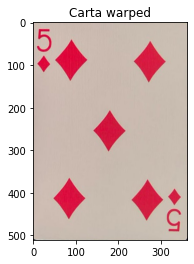

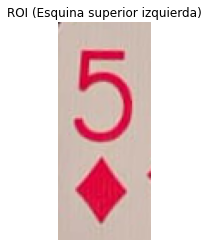

Contornos totales: 13 | Filtrados: 2


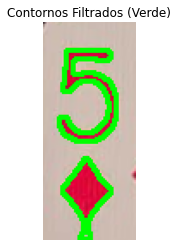

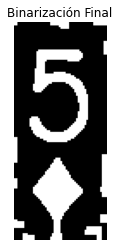

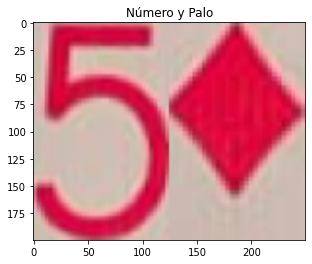

Template mathing:
Ace: score = -0.1173


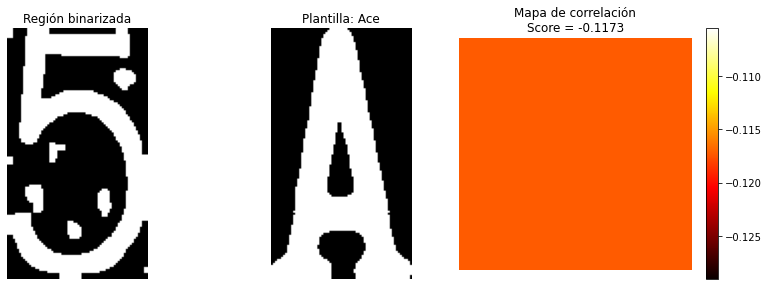

Ace: score = -0.0820


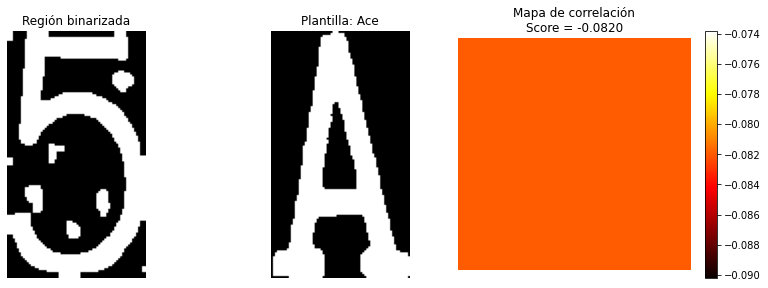

Two: score = 0.1143


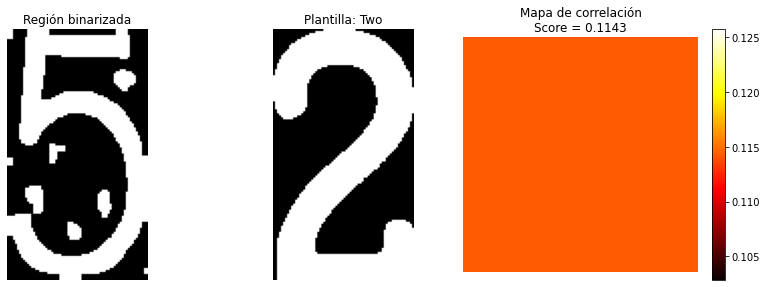

Two: score = 0.1996


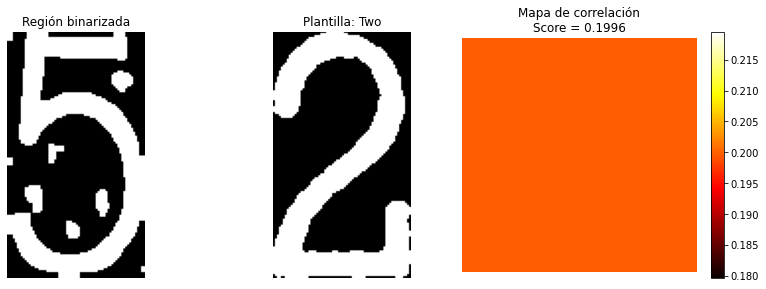

Three: score = 0.3857


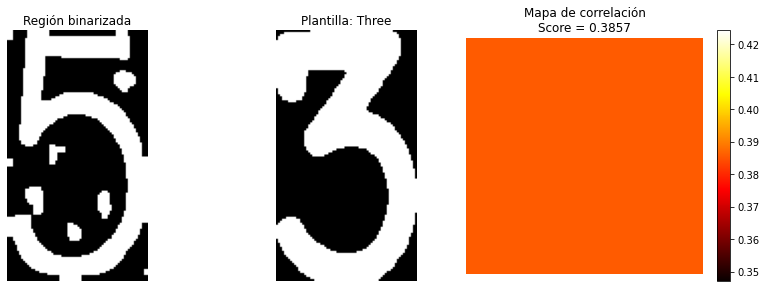

Three: score = 0.4156


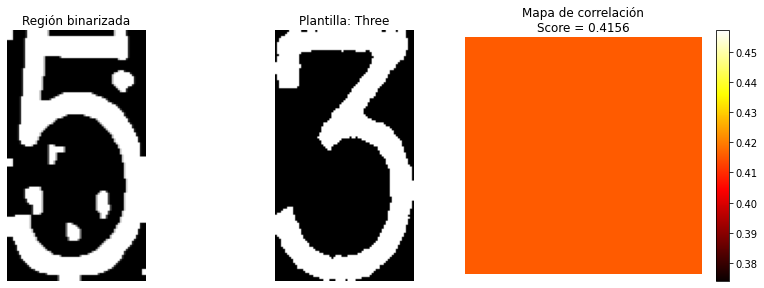

Four: score = -0.0684


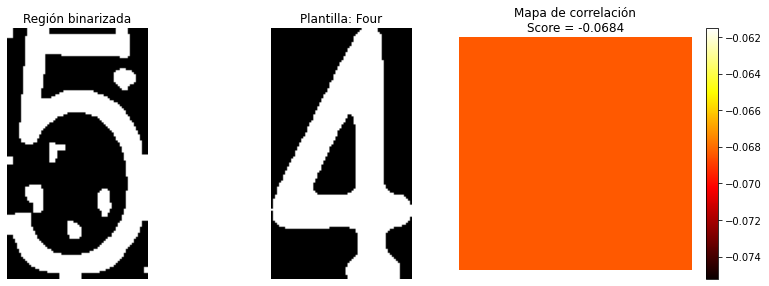

Four: score = -0.0324


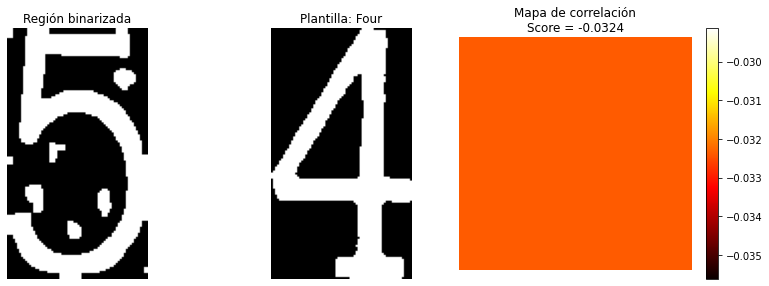

Five: score = 0.7074


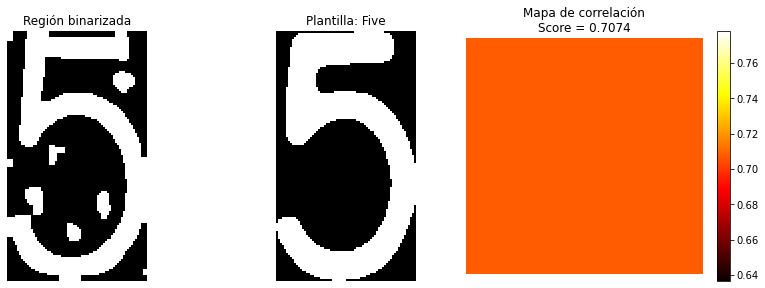

Five: score = 0.4393


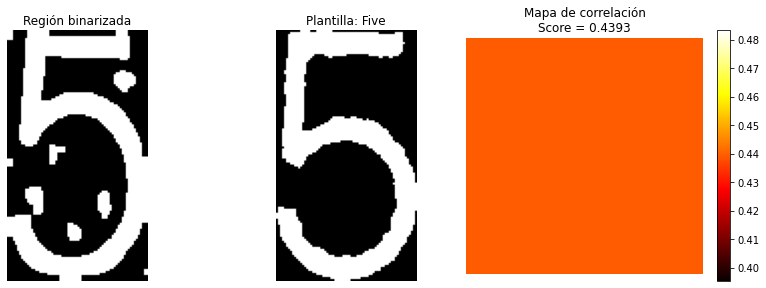

Six: score = 0.4904


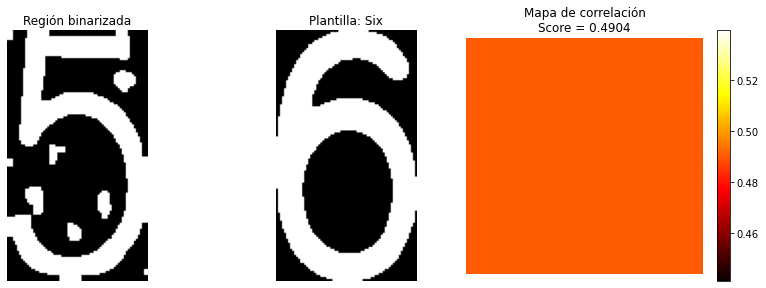

Six: score = 0.3275


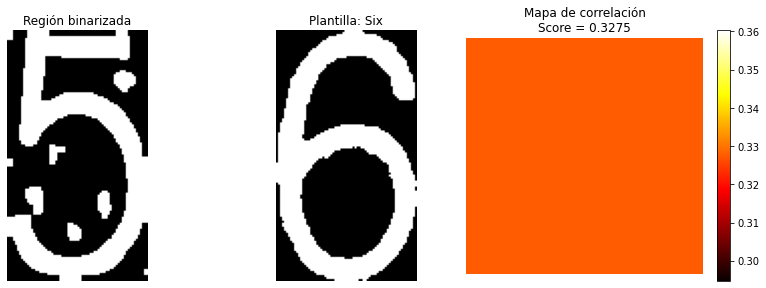

Seven: score = 0.0113


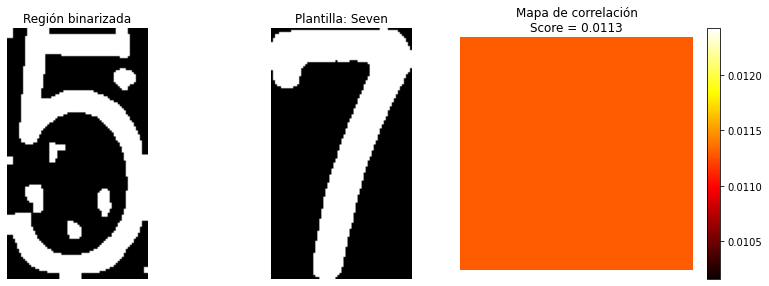

Seven: score = 0.0457


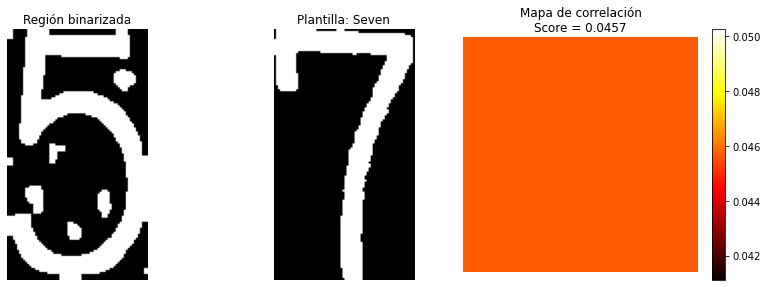

Eight: score = 0.3697


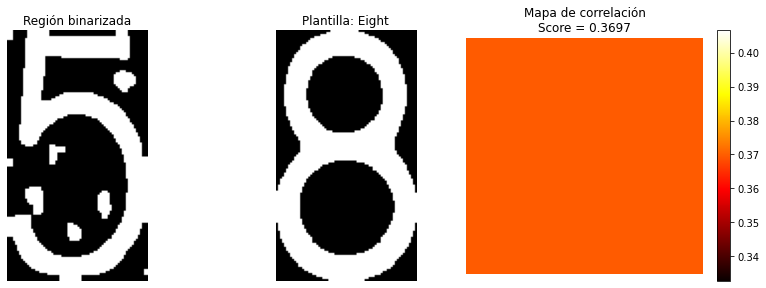

Eight: score = 0.3498


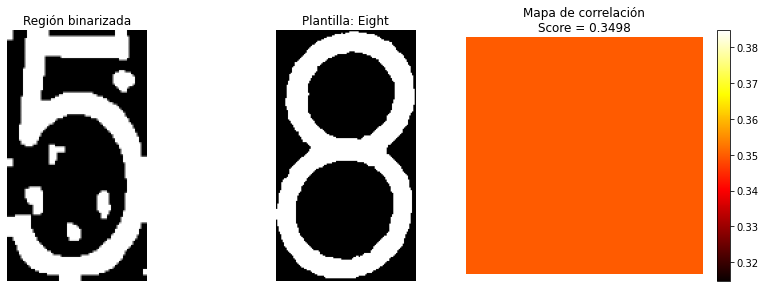

Nine: score = 0.2914


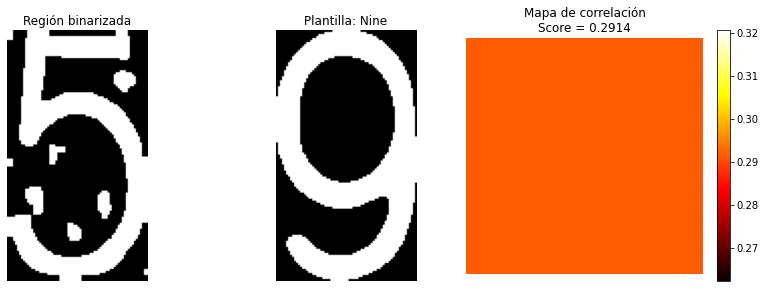

Nine: score = 0.2917


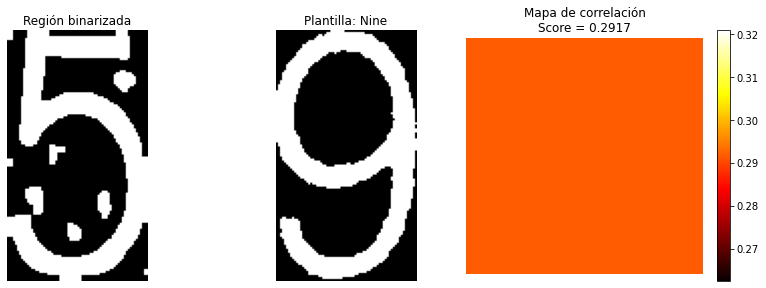

Ten: score = 0.3560


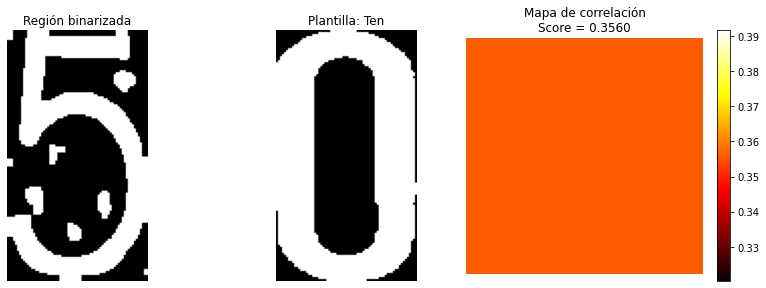

Ten: score = 0.3922


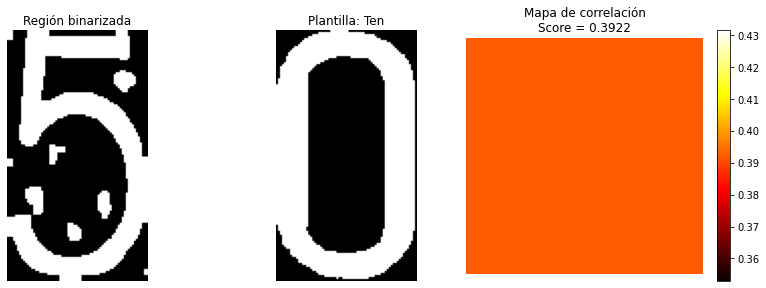

Jack: score = 0.1771


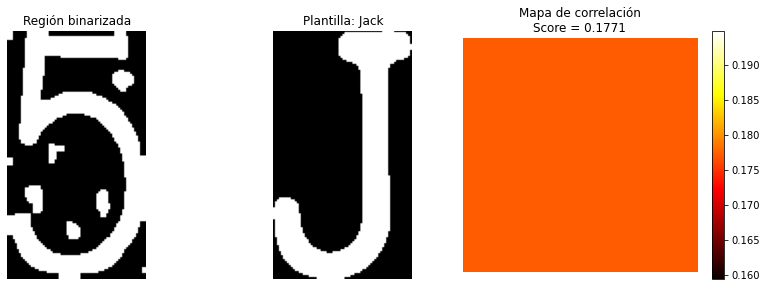

Jack: score = 0.1837


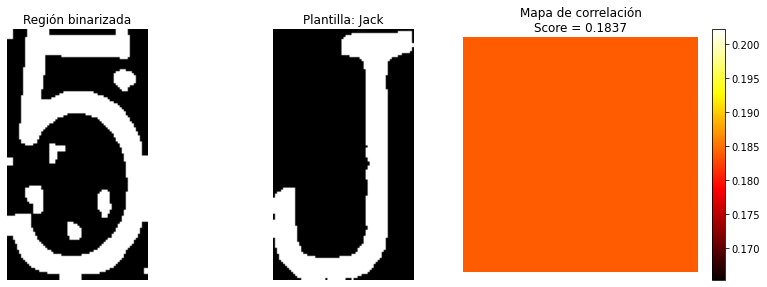

Queen: score = 0.0668


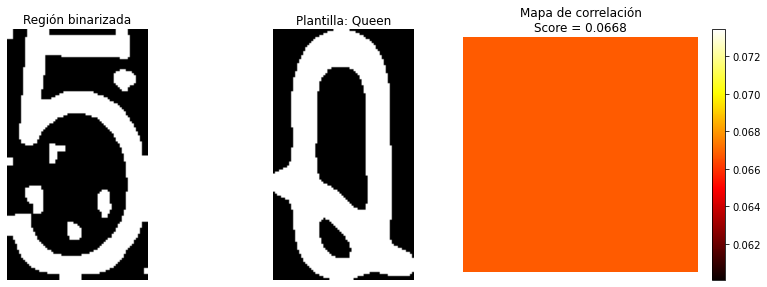

Queen: score = 0.1704


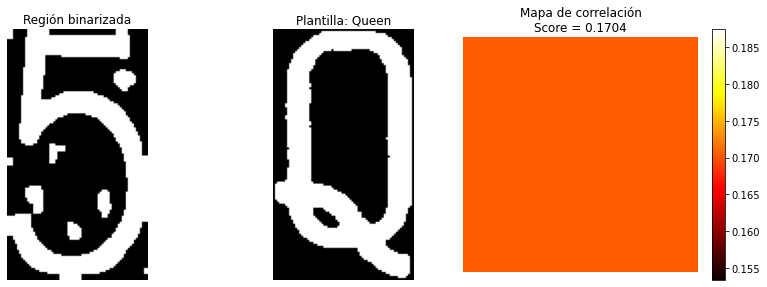

King: score = 0.0830


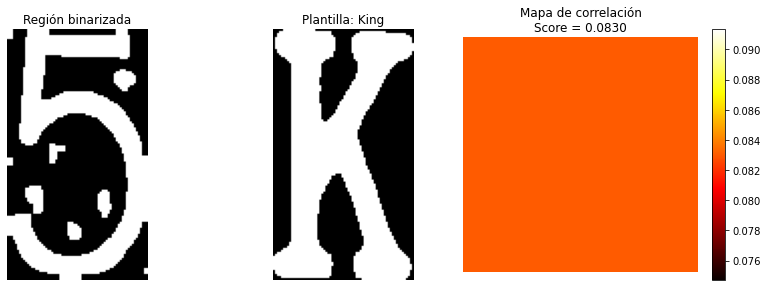

King: score = 0.1077


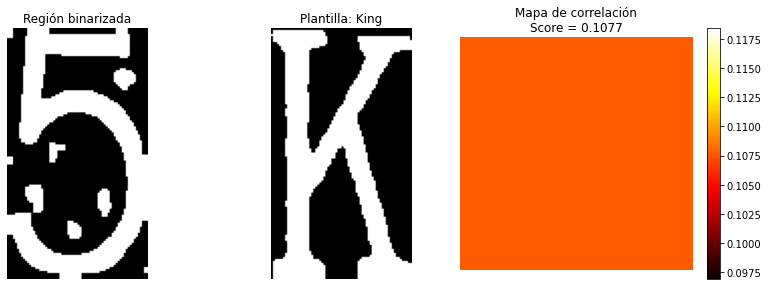

Clubs: score = 0.1598


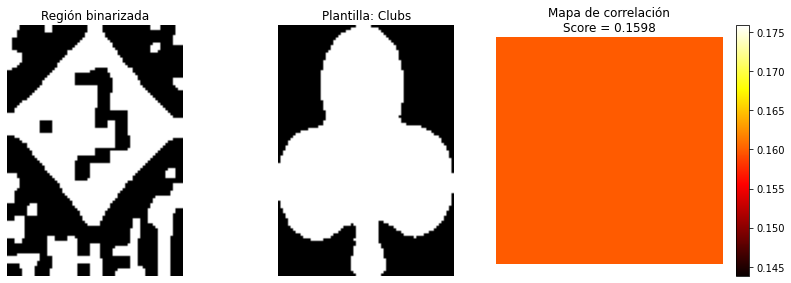

Clubs: score = 0.1527


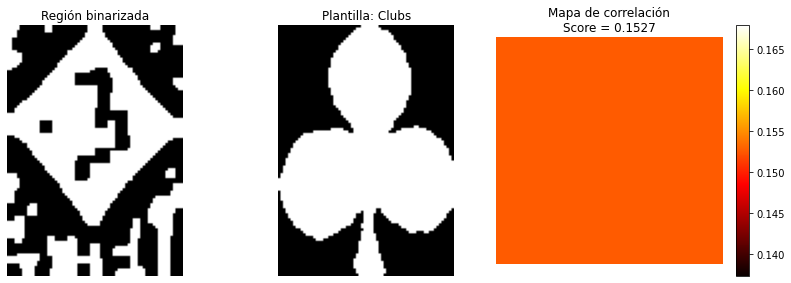

Diamonds: score = 0.2497


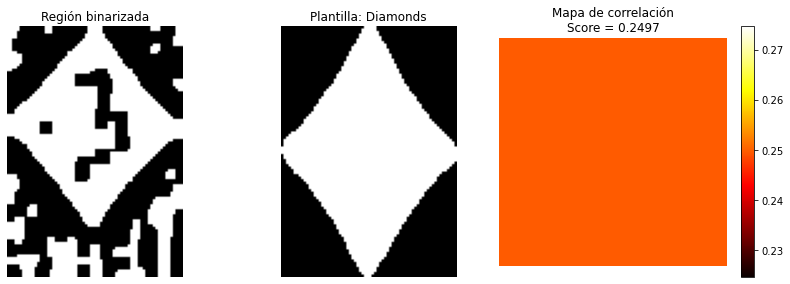

Diamonds: score = 0.2439


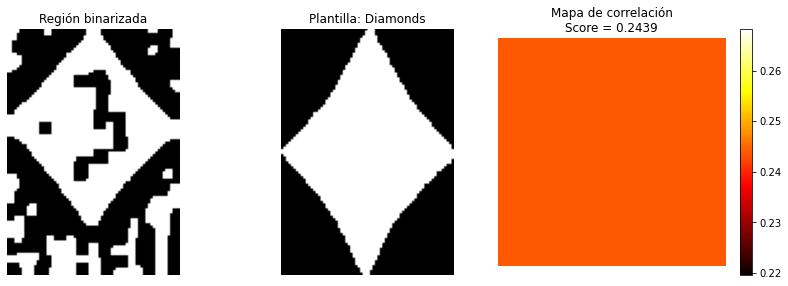

Hearts: score = 0.1079


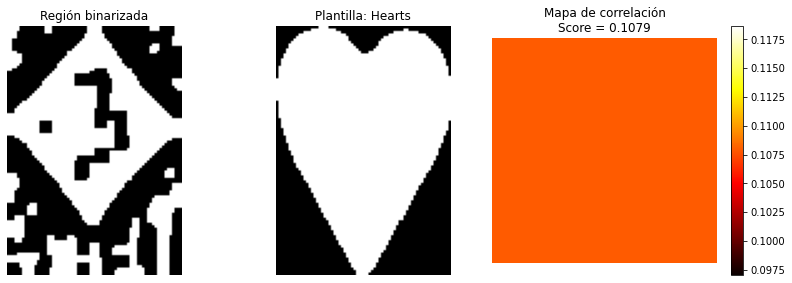

Hearts: score = 0.1556


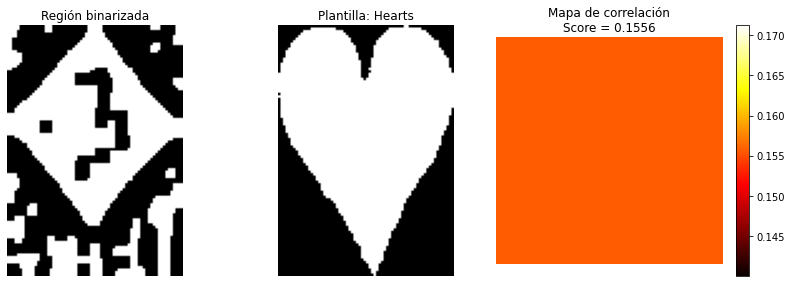

Spades: score = 0.2389


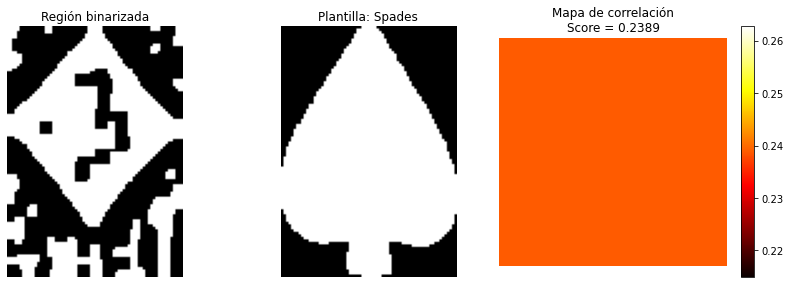

Spades: score = 0.1597


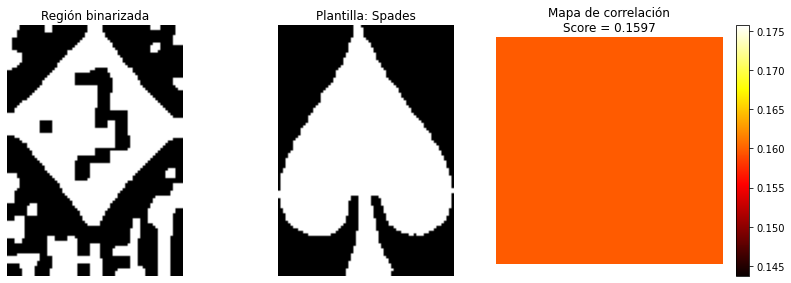

🃏 Carta 2: Five de Diamonds


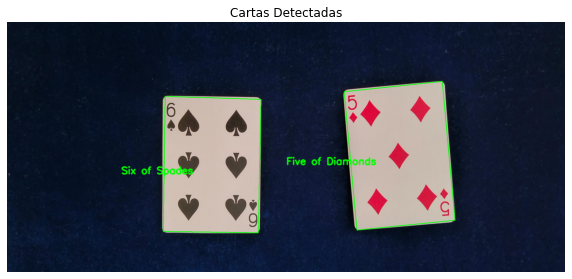

[('Six', 'Spades'), ('Five', 'Diamonds')]
Carta 1: Six de Spades
Carta 2: Five de Diamonds


In [46]:
results = main("Fotos/fotos_multiples/5D6S2.jpg", debug=True)
print(results)
for i, (number, suit) in enumerate(results):
    print(f"Carta {i + 1}: {number} de {suit}")

## 16. Detección de cartas en tiempo real

Esta función activa la cámara web y realiza detección de cartas en tiempo real, mostrando el resultado en una ventana hasta que se presione la tecla `'q'`.

### ¿Qué hace paso a paso?

1. **Inicia la cámara:**
   - Usa `cv2.VideoCapture(1)` para acceder a la cámara (cambia el índice si es necesario).
   - Si no se puede acceder, muestra un mensaje de error y se detiene.

2. **Bucle principal:**
   - Captura frame por frame desde la cámara.
   - Solo procesa un frame cada 5 (`x_frames = 5`) para reducir la carga computacional.

3. **Procesamiento del frame (cada 5 frames):**
   - Preprocesa la imagen para resaltar los bordes: `preprocess_image`.
   - Detecta los contornos de posibles cartas: `find_card_contours`.
   - Carga las plantillas de números y palos: `load_templates`.

4. **Por cada contorno de carta detectado:**
   - Extrae la carta desde la imagen original: `warp_card`.
   - Corrige la orientación de la carta: `correct_card_orientation`.
   - Valida la proporción de la carta: `is_valid_card_proportion`.
   - Extrae las regiones del número y palo: `extract_number_suit_region`.
   - Realiza el reconocimiento mediante plantillas: `match_template`.
   - Si la detección es válida, se almacena en la lista `detected_cards`.

5. **Visualización (si `draw_predictions=True`):**
   - Dibuja contornos y etiquetas (`número + palo`) sobre la imagen original usando:
     - `cv2.putText()`
     - `cv2.drawContours()`
   - Calcula el centro del contorno para ubicar correctamente la etiqueta.

6. **Finalización:**
   - El bucle continúa hasta que el usuario presione la tecla `'q'`.
   - Se liberan los recursos de la cámara y se cierran las ventanas de OpenCV.


In [60]:
import cv2
import time

def run_realtime(debug=False, draw_predictions=True):
    cap = cv2.VideoCapture(1)  # Usa la cámara por defecto

    if not cap.isOpened():
        print("❌ No se pudo acceder a la cámara.")
        return

    print("🎥 Cámara iniciada. Presiona 'q' para salir.")

    x_frames = 5  # Detectar cada 5 frames
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ No se pudo leer el frame.")
            break

        image = frame.copy()
        original = image.copy()

        # Solo ejecutar cada x_frames
        if frame_count % x_frames == 0:
            edges = preprocess_image(image)
            card_contours = find_card_contours(edges)

            number_templates, suit_templates = load_templates()
            detected_cards = []

            for i, contour in enumerate(card_contours):
                warped = warp_card(image, contour)
                if warped is None:
                    continue

                warped = correct_card_orientation(warped, debug)
                if warped is None or not is_valid_card_proportion(warped, debug=debug):
                    continue

                number_region, suit_region = extract_number_suit_region(warped, debug=debug)
                if number_region is not None and suit_region is not None:
                    number = match_template(number_region, number_templates, debug=debug)
                    suit = match_template(suit_region, suit_templates, debug=debug)
                    detected_cards.append((contour, number, suit))

        # Dibujar resultados si se desea
        if draw_predictions and frame_count % x_frames == 0:
            for contour, number, suit in detected_cards:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = contour[0][0]

                label = f"{number} of {suit}"
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                text_x = cx - text_width // 2
                text_y = cy + text_height // 2

                cv2.putText(original, label, (text_x, text_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3, cv2.LINE_AA)
                cv2.drawContours(original, [contour], -1, (0, 255, 0), 2)

        cv2.imshow("Cartas Detectadas (Tiempo Real)", original)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1


    cap.release()
    cv2.destroyAllWindows()


In [61]:
run_realtime(debug=False)


🎥 Cámara iniciada. Presiona 'q' para salir.


C:\Users\migue\AppData\Local\Temp\ipykernel_49676\877530921.py:31: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


In [22]:
import cv2
import time
import os
import csv
from datetime import datetime

# ------ Asegúrate de que estas funciones estén implementadas correctamente en tu código ------
# preprocess_image, find_card_contours, load_templates, warp_card, correct_card_orientation,
# is_valid_card_proportion, extract_number_suit_region, match_template


def run_realtime(debug=False, draw_predictions=True):
    cap = cv2.VideoCapture(1)  # Usa la cámara por defecto

    if not cap.isOpened():
        print("❌ No se pudo acceder a la cámara.")
        return

    print("🎥 Cámara iniciada. Presiona 'q' para salir.")

    # Crear carpeta de resultados si no existe
    resultados_dir = "resultados"
    os.makedirs(resultados_dir, exist_ok=True)

    # Crear CSV si no existe
    csv_path = os.path.join(resultados_dir, "resultados.csv")
    if not os.path.exists(csv_path):
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["FechaHora", "NombreImagen", "Resultados"])

    # Variables para detección de movimiento
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_gray = cv2.GaussianBlur(prev_gray, (21, 21), 0)

    x_frames = 5  # Detectar cada 5 frames
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("⚠️ No se pudo leer el frame.")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (21, 21), 0)

        # Diferencia absoluta entre el frame actual y el anterior
        frame_delta = cv2.absdiff(prev_gray, gray)
        thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]

        # Dilatar el umbral para llenar agujeros, encontrar contornos
        thresh = cv2.dilate(thresh, None, iterations=2)
        motion_contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        motion_detected = any(cv2.contourArea(c) > 5000 for c in motion_contours)

        if motion_detected and frame_count % x_frames == 0:
            print("📸 Movimiento detectado. Procesando cartas...")

            image = frame.copy()
            original = image.copy()

            edges = preprocess_image(image)
            card_contours = find_card_contours(edges)

            number_templates, suit_templates = load_templates()
            detected_cards = []

            for i, contour in enumerate(card_contours):
                warped = warp_card(image, contour)
                if warped is None:
                    continue

                warped = correct_card_orientation(warped, debug)
                if warped is None or not is_valid_card_proportion(warped, debug=debug):
                    continue

                number_region, suit_region = extract_number_suit_region(warped, debug=debug)
                if number_region is not None and suit_region is not None:
                    number = match_template(number_region, number_templates, debug=debug)
                    suit = match_template(suit_region, suit_templates, debug=debug)
                    detected_cards.append((contour, number, suit))

            # Dibujar resultados
            for contour, number, suit in detected_cards:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = contour[0][0]

                label = f"{number} of {suit}"
                (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
                text_x = cx - text_width // 2
                text_y = cy + text_height // 2

                cv2.putText(original, label, (text_x, text_y),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3, cv2.LINE_AA)
                cv2.drawContours(original, [contour], -1, (0, 255, 0), 2)

            # Guardar imagen
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            image_filename = f"captura_{timestamp}.jpg"
            cv2.imwrite(os.path.join(resultados_dir, image_filename), original)

            # Guardar en CSV
            resultados_texto = "; ".join([f"{n} of {s}" for _, n, s in detected_cards])
            with open(csv_path, mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([datetime.now().strftime("%Y-%m-%d %H:%M:%S"), image_filename, resultados_texto])

        # Actualizar el frame anterior
        prev_gray = gray.copy()

        # Mostrar la cámara en vivo
        cv2.imshow("Cartas Detectadas (Tiempo Real)", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


In [42]:
run_realtime(debug=False)

🎥 Cámara iniciada. Presiona 'q' para salir.
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...


C:\Users\migue\AppData\Local\Temp\ipykernel_32372\877530921.py:31: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimiento detectado. Procesando cartas...
📸 Movimien